<a href="https://colab.research.google.com/github/cherg0607yl-coder/Credit-Card-Default---Machine-Learning-Classification-/blob/main/credit_card_default_classfication_tree_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and mount google drive

In [ ]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data

# !pip install optuna
import optuna

# !pip install autofeat
from autofeat import AutoFeatClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
# load the data into a pandas dataframe

data_path = '/content/drive/My Drive/Copy of credit_card_default.csv'
df = pd.read_csv(data_path)

# preview data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   GENDER     30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

,ID,LIMIT_BAL,GENDER,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Data Cleaning

### Client Personal Information
Below we print the numeric distribution of the client personal information features. The LIMIT_BAL, GENDER, and AGE attributes seem to be consistent with the description in dataset dictionary, while MARRIAGE and EDUCATION have some undocumented categories. EDUCATION ranges from 0 to 6, while MARRIAGE starts at category 0.

In [ ]:
df[['LIMIT_BAL', 'GENDER', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()

,LIMIT_BAL,GENDER,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500
std,129747.661567,0.489129,0.790349,0.521970,9.217904
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000


In [ ]:
print(df['GENDER'].value_counts().sort_index())
print(df['EDUCATION'].value_counts().sort_index())
print(df['MARRIAGE'].value_counts().sort_index())

GENDER
1    11888
2    18112
Name: count, dtype: int64
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64


#### Problem 1: Uncategorized elements in MARRIAGE
Marriage should only contain three categories: 1 = married, 2 = single, 3 = other.

But this dataset has 54 data identified as 0.

**To solve this, we map the 0 into "other" category.**

In [ ]:
# Identify the numeric distribution of marriage

df['MARRIAGE'].value_counts().sort_index()

,count
MARRIAGE,
0,54
1,13659
2,15964
3,323


In [ ]:
# Replace 0 with 3

df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)
df['MARRIAGE'].value_counts().sort_index()

,count
MARRIAGE,
1,13659
2,15964
3,377


#### Problem 2: Uncategorized elements in EDUCATION
Education should only contain: 1 = terminal degree, 2 = some graduate school, 3  = bachelor’s degree, 4 = some college, 5 = high school graduate

But this dataset contains unidentified 0 and 6.

**To solve this, considering the anomalous entries are relative few, we decide to remove them.**

In [ ]:
# Identify the numeric distribution of EDUCATION

df['EDUCATION'].value_counts().sort_index()

,count
EDUCATION,
0,14
1,10585
2,14030
3,4917
4,123
5,280
6,51


In [ ]:
# remove uncategorized information in EDUCATION

print(f"Dataset size before:\t{df.shape[0]}")

df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==6].index)

print(f"Dataset size after:\t{df.shape[0]}")

Dataset size before:	30000
Dataset size after:	29935


In [ ]:
# Double-check the numeric distribution of EDUCATION
df['EDUCATION'].value_counts().sort_index()

,count
EDUCATION,
1,10585
2,14030
3,4917
4,123
5,280


### History of Past Payments
Below we print the numeric distribution of the history of past payments. The columns PAY_n range from -2 (undocumented) to 8, therefore, we believe they need to be cleaned to match the dataset dictionary.

In [ ]:
pay_columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_columns:
  print(df[col].value_counts().sort_index())

PAY_1
-2     2750
-1     5675
 0    14700
 1     3685
 2     2662
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64
PAY_2
-2     3772
-1     6036
 0    15691
 1       28
 2     3925
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64
PAY_3
-2     4074
-1     5924
 0    15726
 1        4
 2     3817
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
Name: count, dtype: int64
PAY_4
-2     4336
-1     5672
 0    16420
 1        2
 2     3156
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
Name: count, dtype: int64
PAY_5
-2     4535
-1     5520
 0    16912
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
Name: count, dtype: int64
PAY_6
-2     4878
-1     5722
 0    16256
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
Name: count, dtype: int64


#### Problem 3: Uncategorized elements in PAY_N
PAY_N should only contain: -1 = paid on time, 1 = 1 month late, 2 = 2 months late, etc, so it should only represent -1,1,2,3,4,5,6,7,8

But it also has 0 and -2.

**To solve this issue, we change 0 into paid on time, and we map -1 and -2 into paid on time.**


In [ ]:
pay_columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_columns:
    df[col] = df[col].replace([-1, -2], 0)
    print(f"Value counts for {col} after replacement:\n{df[col].value_counts()}\n")

Value counts for PAY_1 after replacement:
PAY_1
0    23125
1     3685
2     2662
3      322
4       76
5       26
8       19
6       11
7        9
Name: count, dtype: int64

Value counts for PAY_2 after replacement:
PAY_2
0    25499
2     3925
3      326
4       99
1       28
5       25
7       20
6       12
8        1
Name: count, dtype: int64

Value counts for PAY_3 after replacement:
PAY_3
0    25724
2     3817
3      240
4       76
7       27
6       23
5       21
1        4
8        3
Name: count, dtype: int64

Value counts for PAY_4 after replacement:
PAY_4
0    26428
2     3156
3      180
4       69
7       58
5       35
6        5
1        2
8        2
Name: count, dtype: int64

Value counts for PAY_5 after replacement:
PAY_5
0    26967
2     2626
3      178
4       84
7       58
5       17
6        4
8        1
Name: count, dtype: int64

Value counts for PAY_6 after replacement:
PAY_6
0    26856
2     2766
3      184
4       49
7       46
6       19
5       13
8        2
Name:

### Amount of the credit card bill statement every month
Below we print the numeric distribution of the amount of the credit card bill statement every month to check whether it has data cleaning problems.

In [ ]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29935.000000,29935.000000,2.993500e+04,29935.000000,29935.000000,29935.000000
mean,51189.061734,49147.825923,4.698679e+04,43258.203842,40319.634341,38886.269818
std,73596.497170,71130.117609,6.930392e+04,64310.420098,60774.878843,59558.149984
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3557.500000,2984.000000,2.663000e+03,2331.000000,1770.500000,1261.000000
50%,22369.000000,21191.000000,2.008600e+04,19052.000000,18121.000000,17106.000000
75%,67061.500000,63939.500000,6.013000e+04,54523.000000,50213.000000,49221.500000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


### Amount of the credit card payment every month
Below we print the numeric distribution of the amount of the credit card payment every month to check whether it has data cleaning problems.

In [ ]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29935.000000,2.993500e+04,29935.000000,29935.000000,29935.000000,29935.000000
mean,5656.434642,5.917404e+03,5219.876432,4826.038550,4788.702088,5200.250777
std,16548.006813,2.305293e+04,17598.889632,15675.217158,15216.459325,17715.287437
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.320000e+02,390.000000,296.000000,254.500000,120.500000
50%,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4503.000000,4014.000000,4032.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


As we observe so far, there are no obvious data cleaning problems within these two categories.

# EDA (Exploratory Data Analysis)
1. The distribution of y-variable (default vs. non-default)
2. The distribution of categorial variables & vs. default, non-default
3. The distribution of numerical variables & vs. default, non-default
4. Correlation heatmap

### 1. The distribution of default and non-default
Understanding how target variable Default is distributed helps us identity the patterns of y-variable and check whether the dataset has data imbalance issues, which is very important for building classification tree model.



From this distribution graph, we can find an obvious imbalance of y-variable in the dataset: 77.9% is customers who have **not** defaulted on their credit cards, and 22.1% did, which can make the resulting classification model more incline to predict non-default than default if use this dataset.

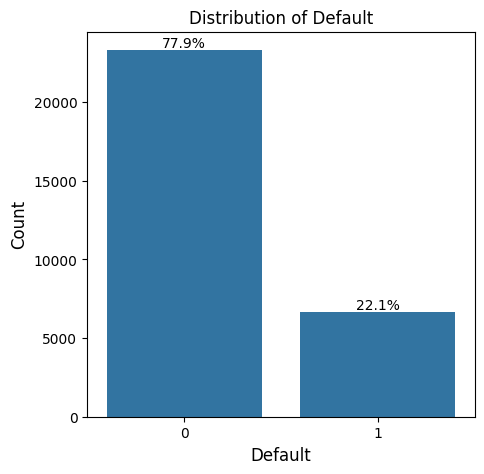

In [ ]:
# Visualization of the distribution of Default in the dataset

default_count = df["DEFAULT"].value_counts()

plt.figure(figsize=(5,5))
ax = sns.barplot(x=default_count.index, y=default_count.values)
plt.title('Distribution of Default')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Default', fontsize=12)

# Annotate the percentage onto the graph
total = len(df["DEFAULT"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

### 2. The distribution of categorial variables & vs. default, non-default
Understanding how each categorical variable is distributed across the default and non-default groups helps us identify potential patterns and relationships in the dataset.

We need this information to check **whether the proportion of DEFAULTERS and NON-DEFAULTERS is in line per each value with the categories of the three variables**.

We examine the following categorical features: GENDER, EDUCATION, MARRIAGE, PAY_1 through PAY_6



#### GENDER in terms of Default and Non-default

In this dataset, it has more female than male, and, in particularly, male has a little bit higher probability of default than female (24.20% vs. 20.79%).

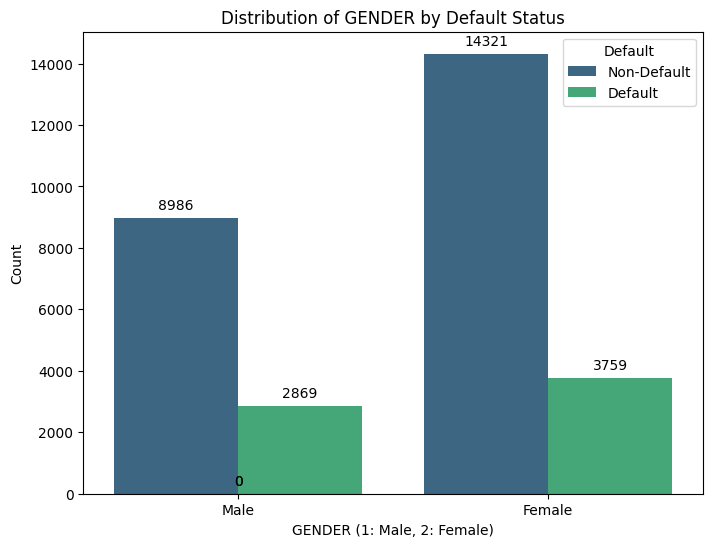

In [ ]:
# The distribution GENDER in terms of Default and Non-default

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='GENDER', hue='DEFAULT', palette='viridis')
plt.title('Distribution of GENDER by Default Status')
plt.xlabel('GENDER (1: Male, 2: Female)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.legend(title='Default', labels=['Non-Default', 'Default'])

# Add count on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

In [ ]:
# The probability of Male Default and Female Default

male_total = df[df['GENDER'] == 1].shape[0]
female_total = df[df['GENDER'] == 2].shape[0]

male_default = df[(df['GENDER'] == 1) & (df['DEFAULT'] == 1)].shape[0]
male_non_default = male_total - male_default

female_default = df[(df['GENDER'] == 2) & (df['DEFAULT'] == 1)].shape[0]
female_non_default = female_total - female_default

male_default_rate = (male_default / male_total) * 100
male_non_default_rate = (male_non_default / male_total) * 100

female_default_rate = (female_default / female_total) * 100
female_non_default_rate = (female_non_default / female_total) * 100

overall_default_rate = (df['DEFAULT'].value_counts(normalize=True)[1]) * 100

print(f'--- Male (Total: {male_total}) ---')
print(f'Number of Male Defaulters: {male_default}')
print(f'Number of Male Non-Defaulters: {male_non_default}')
print(f'Default Rate for Males: {male_default_rate:.2f}%')
print(f'Non-Default Rate for Males: {male_non_default_rate:.2f}%')

print(f'\n--- Female (Total: {female_total}) ---')
print(f'Number of Female Defaulters: {female_default}')
print(f'Number of Female Non-Defaulters: {female_non_default}')
print(f'Default Rate for Females: {female_default_rate:.2f}%')
print(f'Non-Default Rate for Females: {female_non_default_rate:.2f}%')

--- Male (Total: 11855) ---
Number of Male Defaulters: 2869
Number of Male Non-Defaulters: 8986
Default Rate for Males: 24.20%
Non-Default Rate for Males: 75.80%

--- Female (Total: 18080) ---
Number of Female Defaulters: 3759
Number of Female Non-Defaulters: 14321
Default Rate for Females: 20.79%
Non-Default Rate for Females: 79.21%


#### EDUCATION in terms of Default and Non-default
In this dataset, it has way more Terminal, Graduate and Bachelor's than some college and high school.

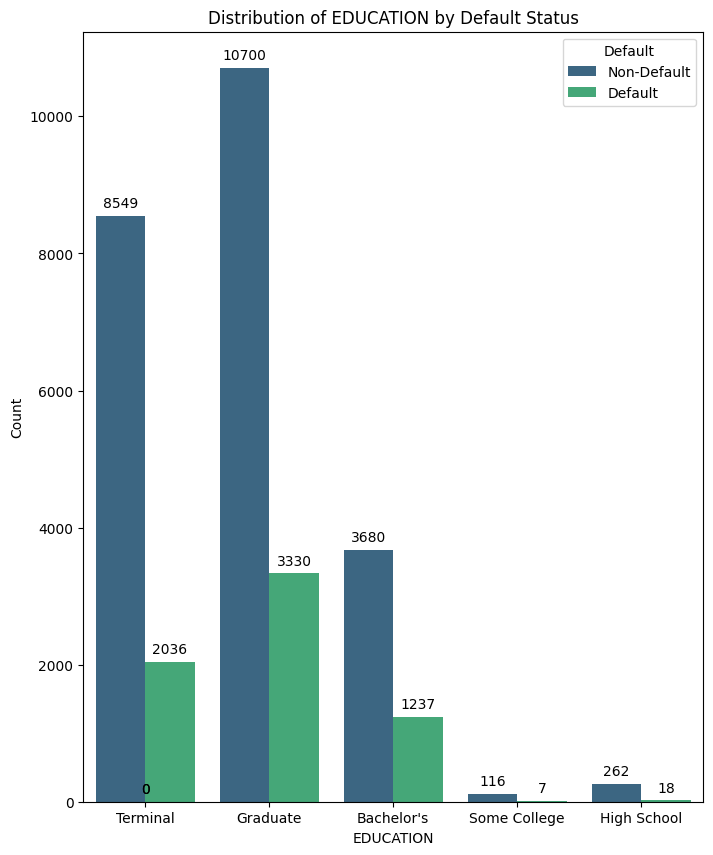

In [ ]:
# The Distribution EDUCATION in terms of Default and Non-default

plt.figure(figsize=(8, 10))
ax = sns.countplot(data=df, x='EDUCATION', hue='DEFAULT', palette='viridis')
plt.title('Distribution of EDUCATION by Default Status')
plt.xlabel('EDUCATION')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Terminal', 'Graduate', "Bachelor's", "Some College", "High School"])
plt.legend(title='Default', labels=['Non-Default', 'Default'])

# Add count on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

In [ ]:
education_categories = df['EDUCATION'].unique()
education_categories.sort()

for edu_cat in education_categories:
    total_count = df[df['EDUCATION'] == edu_cat].shape[0]
    default_count = df[(df['EDUCATION'] == edu_cat) & (df['DEFAULT'] == 1)].shape[0]
    non_default_count = total_count - default_count

    if total_count > 0:
        default_rate = (default_count / total_count) * 100
        non_default_rate = (non_default_count / total_count) * 100
    else:
        default_rate = 0.0
        non_default_rate = 0.0

    education_label_map = {
        1: 'Terminal',
        2: 'Graduate',
        3: 'Bachelor',
        4: 'College',
        5: 'HighSchool'
    }

    # Use the label map for printing, default to category number if not found
    edu_label = education_label_map.get(edu_cat, str(edu_cat))

    print(f'--- EDUCATION: {edu_label} (Total: {total_count}) ---')
    print(f'Number of Defaulters: {default_count}')
    print(f'Number of Non-Defaulters: {non_default_count}')
    print(f'Default Rate: {default_rate:.2f}%')
    print(f'Non-Default Rate: {non_default_rate:.2f}%\n')

--- EDUCATION: Terminal (Total: 10585) ---
Number of Defaulters: 2036
Number of Non-Defaulters: 8549
Default Rate: 19.23%
Non-Default Rate: 80.77%

--- EDUCATION: Graduate (Total: 14030) ---
Number of Defaulters: 3330
Number of Non-Defaulters: 10700
Default Rate: 23.73%
Non-Default Rate: 76.27%

--- EDUCATION: Bachelor (Total: 4917) ---
Number of Defaulters: 1237
Number of Non-Defaulters: 3680
Default Rate: 25.16%
Non-Default Rate: 74.84%

--- EDUCATION: College (Total: 123) ---
Number of Defaulters: 7
Number of Non-Defaulters: 116
Default Rate: 5.69%
Non-Default Rate: 94.31%

--- EDUCATION: HighSchool (Total: 280) ---
Number of Defaulters: 18
Number of Non-Defaulters: 262
Default Rate: 6.43%
Non-Default Rate: 93.57%



#### Marriage in terms of Default and Non-default

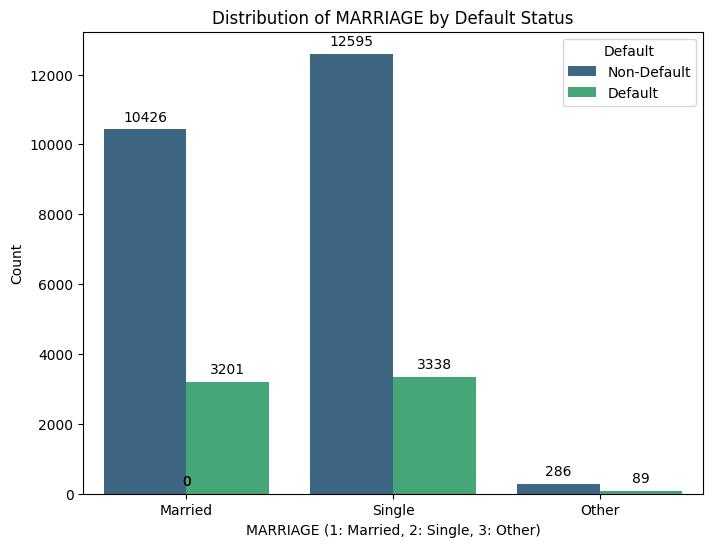

In [ ]:
# The distribution MARRIAGE in terms of Default and Non-default

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='MARRIAGE', hue='DEFAULT', palette='viridis')
plt.title('Distribution of MARRIAGE by Default Status')
plt.xlabel('MARRIAGE (1: Married, 2: Single, 3: Other)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Married', 'Single', 'Other'])
plt.legend(title='Default', labels=['Non-Default', 'Default'])

# Add count on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

In [ ]:
marriage_categories = df['MARRIAGE'].unique()
marriage_categories.sort()

for mar_cat in marriage_categories:
    total_count = df[df['MARRIAGE'] == mar_cat].shape[0]
    default_count = df[(df['MARRIAGE'] == mar_cat) & (df['DEFAULT'] == 1)].shape[0]
    non_default_count = total_count - default_count

    if total_count > 0:
        default_rate = (default_count / total_count) * 100
        non_default_rate = (non_default_count / total_count) * 100
    else:
        default_rate = 0.0
        non_default_rate = 0.0

    marriage_label_map = {
        1: 'Married',
        2: 'Single',
        3: 'Other'
    }

    # Use the label map for printing, default to category number if not found
    mar_label = marriage_label_map.get(mar_cat, str(mar_cat))

    print(f'--- MARRIAGE: {mar_label} (Total: {total_count}) ---')
    print(f'Number of Defaulters: {default_count}')
    print(f'Number of Non-Defaulters: {non_default_count}')
    print(f'Default Rate: {default_rate:.2f}%')
    print(f'Non-Default Rate: {non_default_rate:.2f}%\n')

--- MARRIAGE: Married (Total: 13627) ---
Number of Defaulters: 3201
Number of Non-Defaulters: 10426
Default Rate: 23.49%
Non-Default Rate: 76.51%

--- MARRIAGE: Single (Total: 15933) ---
Number of Defaulters: 3338
Number of Non-Defaulters: 12595
Default Rate: 20.95%
Non-Default Rate: 79.05%

--- MARRIAGE: Other (Total: 375) ---
Number of Defaulters: 89
Number of Non-Defaulters: 286
Default Rate: 23.73%
Non-Default Rate: 76.27%



#### PAY_N in terms of Default and Non-default

Across all six repayment months, customers who paid on time (Delay = 0) have the lowest default rates (around 16%). As repayment delays increase, default rates increase. This relationship is strongest for the most recent payment month (PAY_1), where a delay of 2 or more months corresponds to default rates above 65–75%.

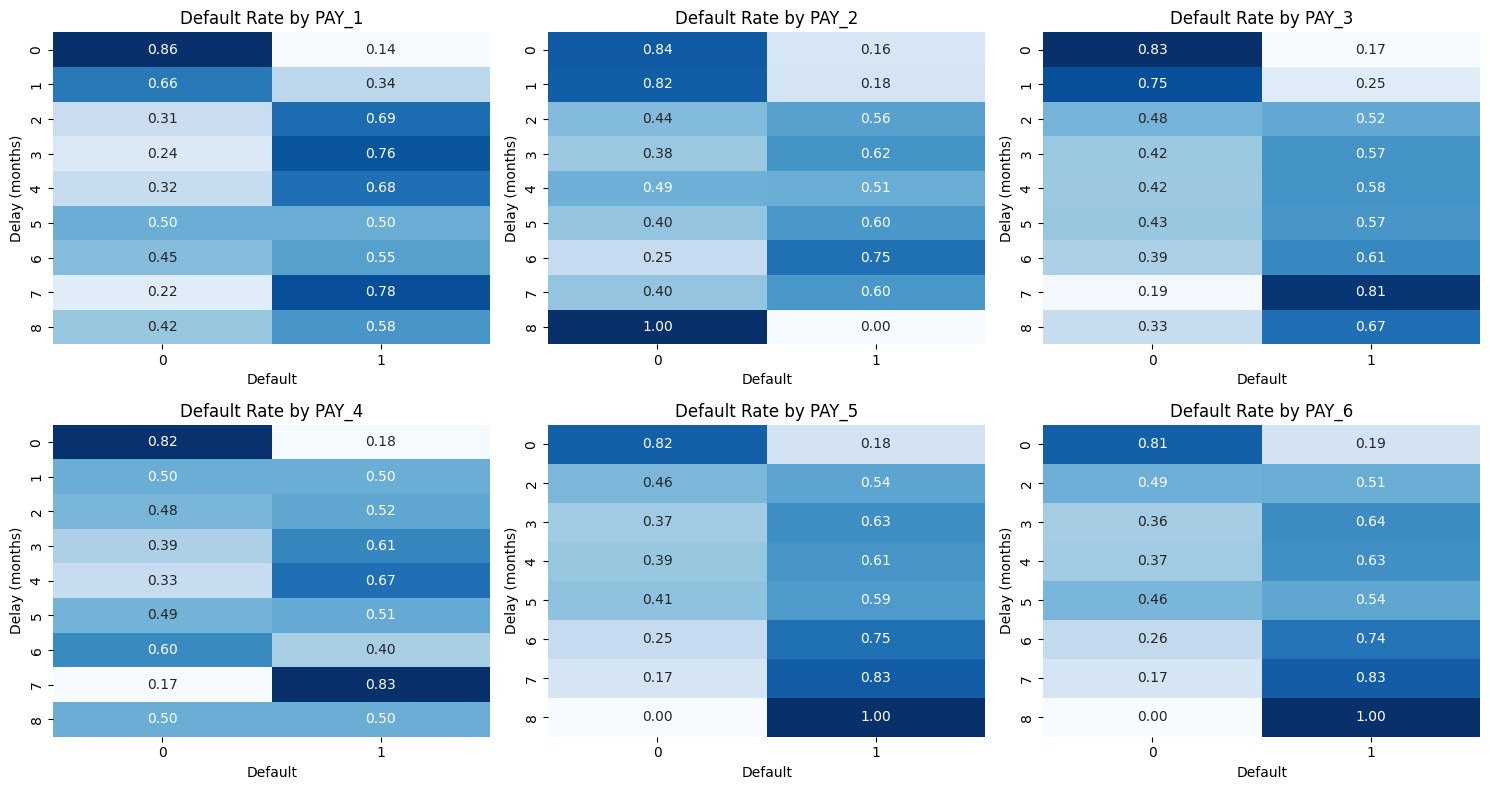

In [ ]:
pay_cols = ["PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(pay_cols):
    # Create percentage table
    table = pd.crosstab(df[col], df['DEFAULT'], normalize='index')

    sns.heatmap(table, annot=True, cmap="Blues", fmt=".2f",
                ax=axes[i], cbar=False)

    axes[i].set_title(f"Default Rate by {col}")
    axes[i].set_xlabel("Default")
    axes[i].set_ylabel("Delay (months)")

plt.tight_layout()
plt.show()

### 3. The distribution of numerical variables & vs. default, non-default
Understanding how each numarical variable is distributed across the default and non-default groups helps us identify potential patterns and relationships in the dataset.

Kernel Density Estimation (KDE) plots are smooth curves that represent the distribution of a continuous / numerical variable. Instead of displaying raw frequencies like a histogram, KDE plots estimate the probability density function and show the shape of the data more clearly.

We examine the following numerical features: AGE, Limit_bal, Bill_amt1 through Bill_amt6, Pay_amt1 through Pay_amt6

#### AGE in terms of Default and Non-default

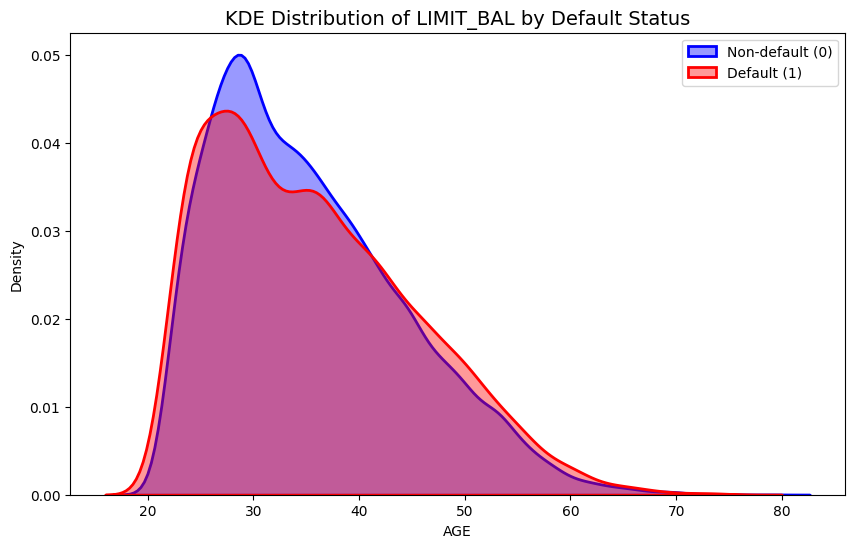

In [ ]:
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df[df["DEFAULT"] == 0],
    x="AGE",
    fill=True,
    alpha=0.4,
    linewidth=2,
    label="Non-default (0)",
    color="blue"
)

sns.kdeplot(
    data=df[df["DEFAULT"] == 1],
    x="AGE",
    fill=True,
    alpha=0.4,
    linewidth=2,
    label="Default (1)",
    color="red"
)

plt.title("KDE Distribution of LIMIT_BAL by Default Status", fontsize=14)
plt.xlabel("AGE")
plt.ylabel("Density")
plt.legend()
plt.show()

#### LIMIT_bal in terms of Default and Non-default

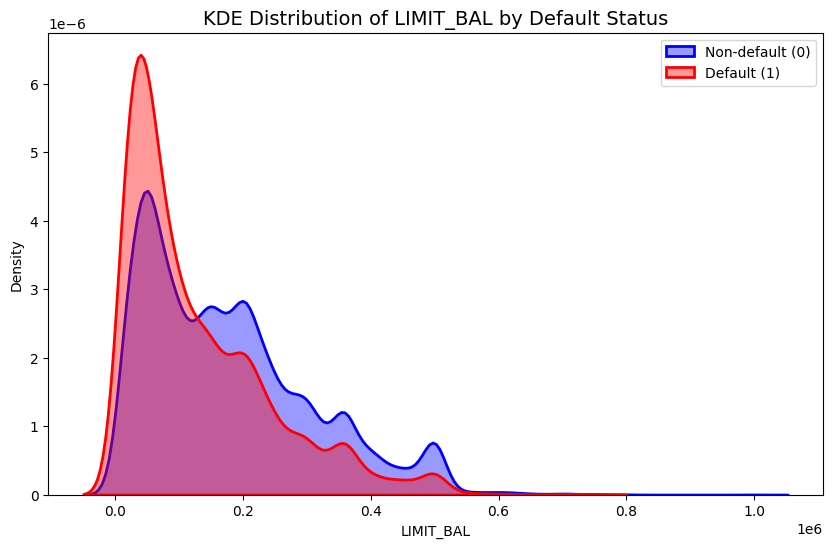

In [ ]:
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df[df["DEFAULT"] == 0],
    x="LIMIT_BAL",
    fill=True,
    alpha=0.4,
    linewidth=2,
    label="Non-default (0)",
    color="blue"
)

sns.kdeplot(
    data=df[df["DEFAULT"] == 1],
    x="LIMIT_BAL",
    fill=True,
    alpha=0.4,
    linewidth=2,
    label="Default (1)",
    color="red"
)

plt.title("KDE Distribution of LIMIT_BAL by Default Status", fontsize=14)
plt.xlabel("LIMIT_BAL")
plt.ylabel("Density")
plt.legend()
plt.show()

#### Bill_amtn in terms of Default and Non-default

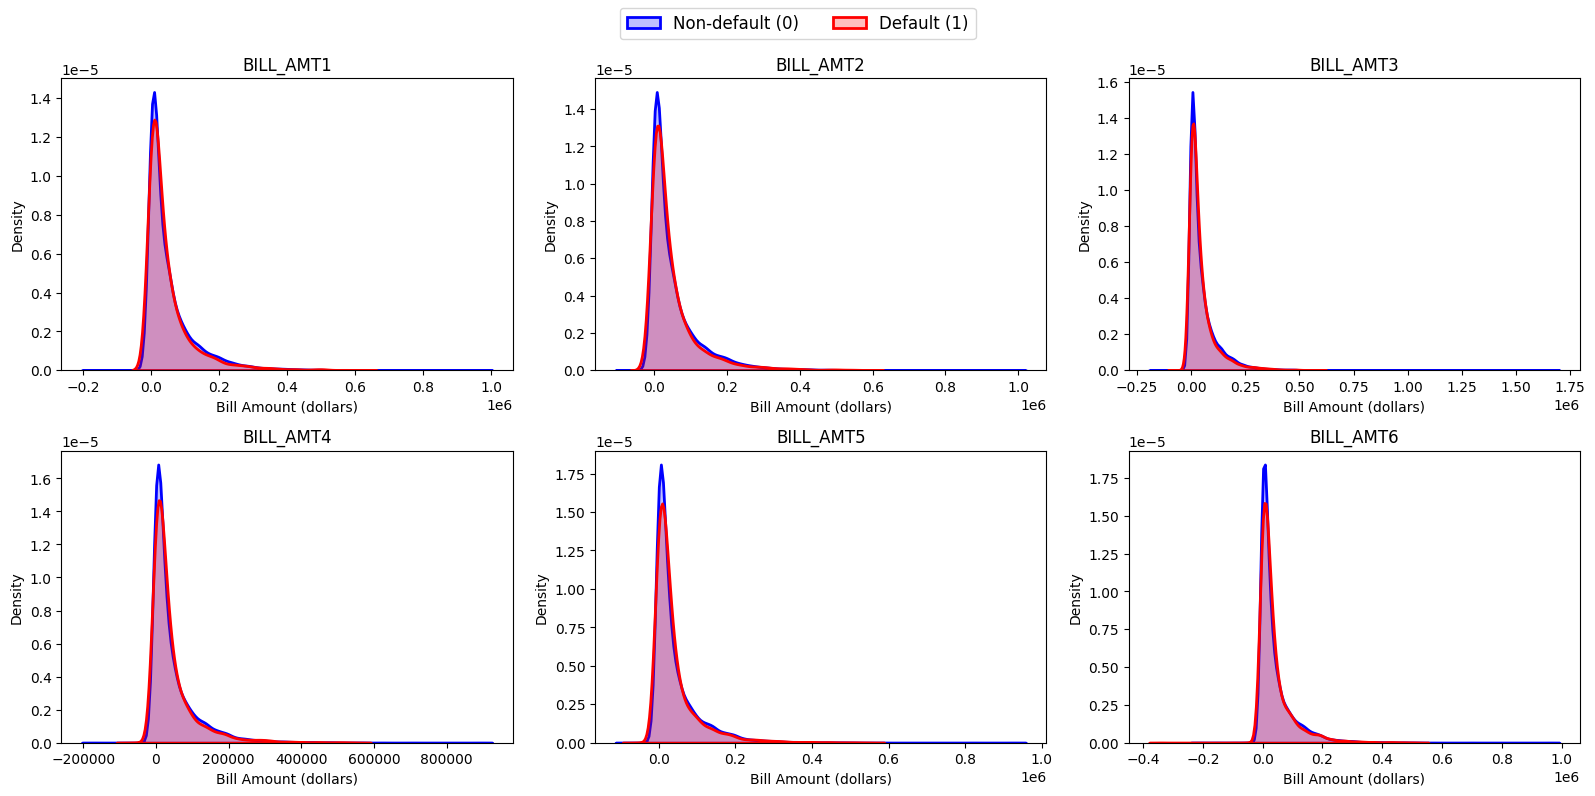

In [ ]:
bill_cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3",
             "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(bill_cols):

    # Non-default KDE
    sns.kdeplot(
        data=df[df["DEFAULT"] == 0],
        x=col,
        bw_adjust=1.3,
        ax=axes[i],
        fill=True,
        color="blue",
        linewidth=2,
        label="Non-default (0)" if i == 0 else ""
    )

    # Default KDE
    sns.kdeplot(
        data=df[df["DEFAULT"] == 1],
        x=col,
        bw_adjust=1.3,
        ax=axes[i],
        fill=True,
        color="red",
        linewidth=2,
        label="Default (1)" if i == 0 else ""
    )

    axes[i].set_title(col)
    axes[i].set_xlabel("Bill Amount (dollars)")
    axes[i].set_ylabel("Density")

# One legend for all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Pay_amtn in terms of Default and Non-default

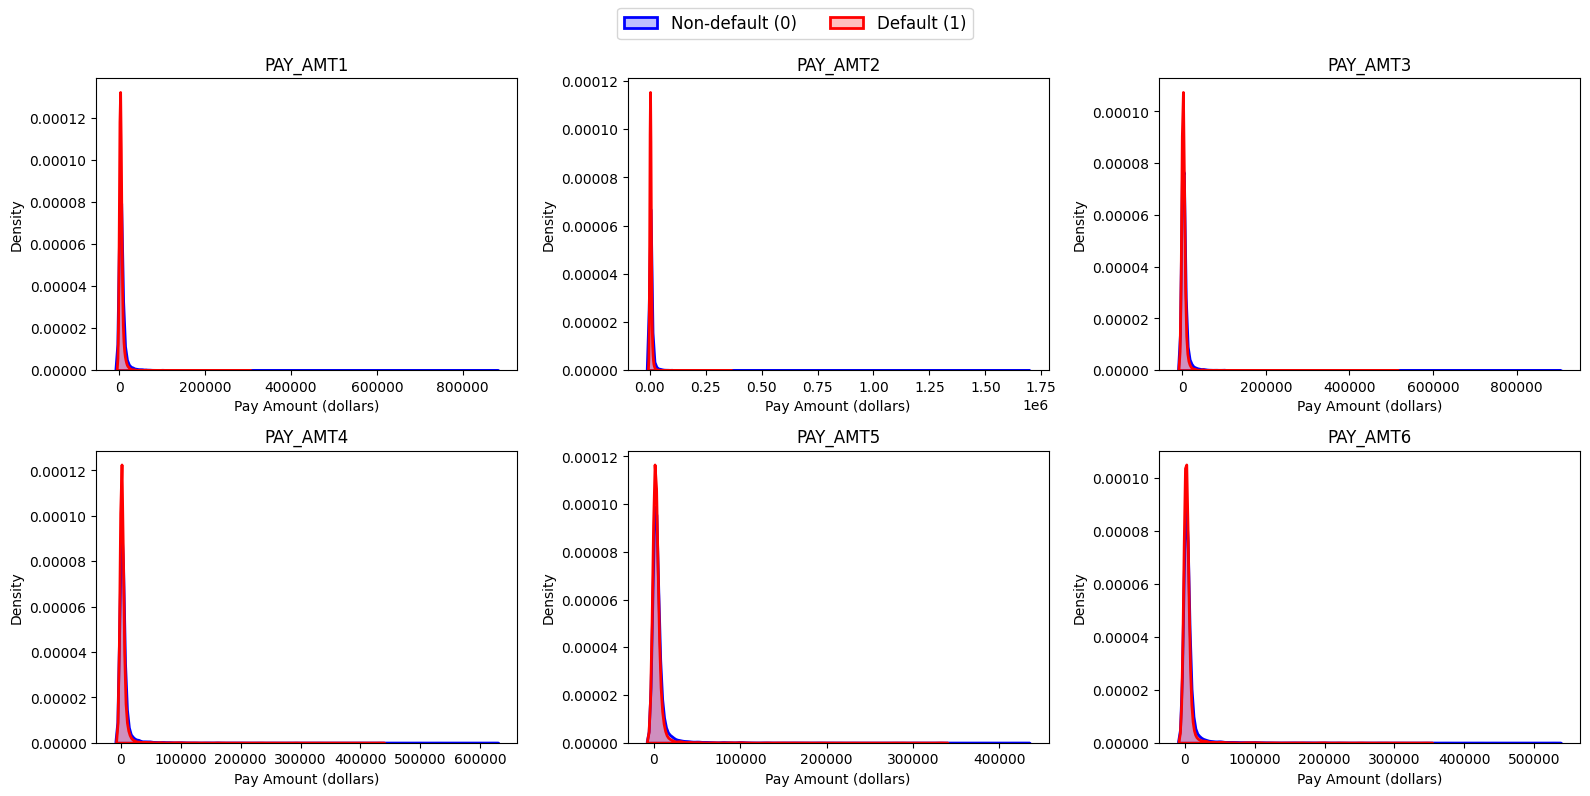

In [ ]:
pay_atm_cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3",
             "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(pay_atm_cols):

    # Non-default KDE
    sns.kdeplot(
        data=df[df["DEFAULT"] == 0],
        x=col,
        bw_adjust=1.3,
        ax=axes[i],
        fill=True,
        color="blue",
        linewidth=2,
        label="Non-default (0)" if i == 0 else ""
    )

    # Default KDE
    sns.kdeplot(
        data=df[df["DEFAULT"] == 1],
        x=col,
        bw_adjust=1.3,
        ax=axes[i],
        fill=True,
        color="red",
        linewidth=2,
        label="Default (1)" if i == 0 else ""
    )

    axes[i].set_title(col)
    axes[i].set_xlabel("Pay Amount (dollars)")
    axes[i].set_ylabel("Density")

# One legend for all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 4. Correlation Heatmap
Check whether each feature has linear relationship with target variable.

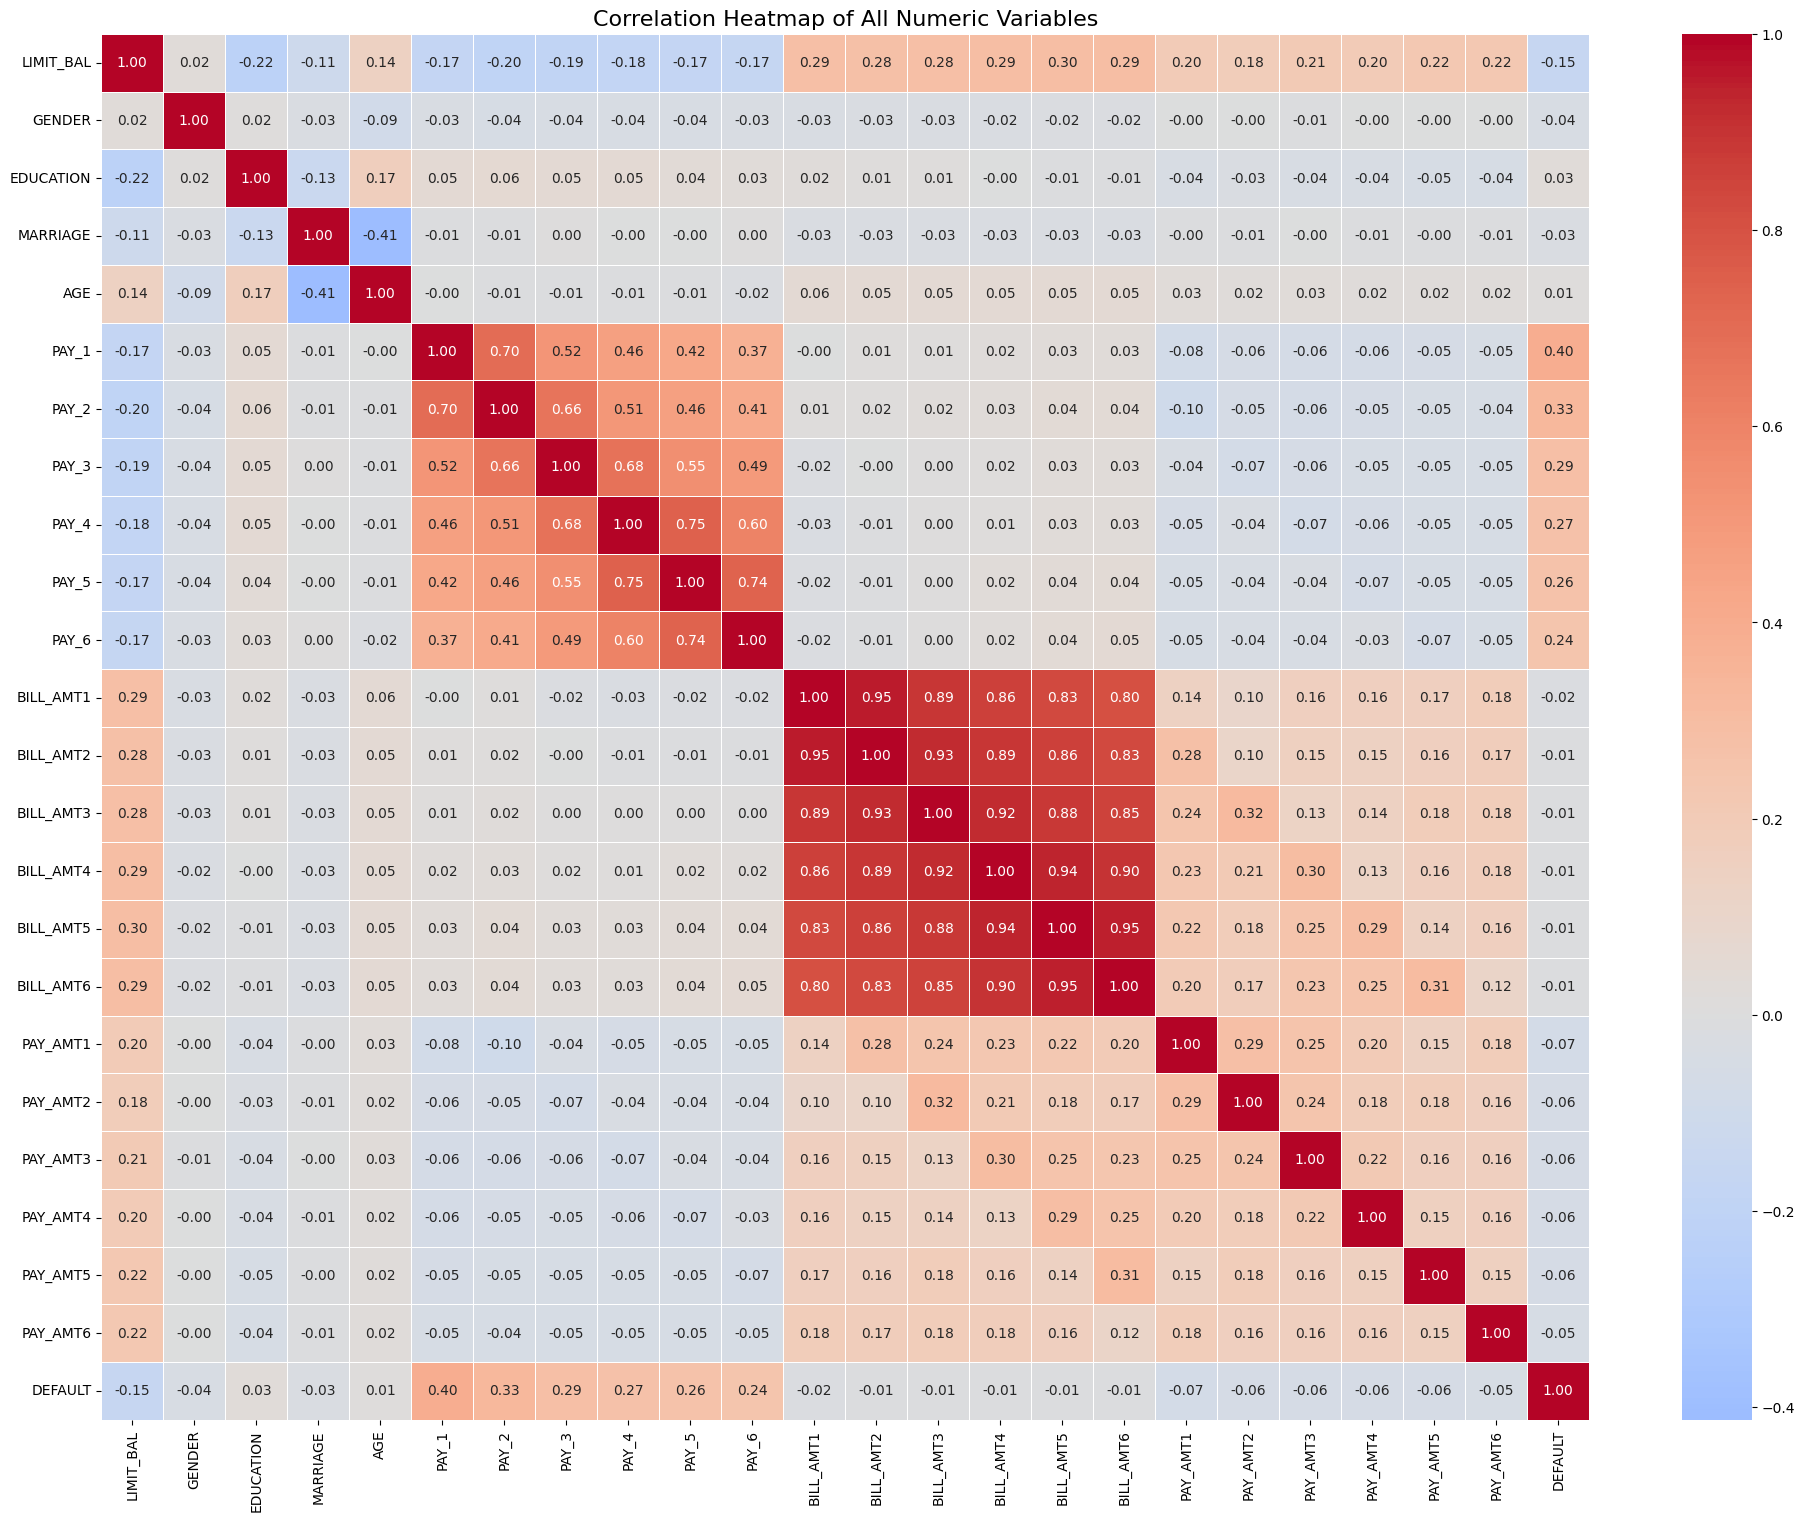

In [ ]:
plt.figure(figsize=(24, 18))

df_copy = df.copy()
df_copy = df_copy.drop(columns=['ID'])
corr = df_copy.corr()   # compute correlation matrix

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Correlation Heatmap of All Numeric Variables", fontsize=16)
plt.show()

# Preprocess Data for building classification tree model


*   Drop unnecessary variables
*   Convert target variables from integer to categorial



### Drop unnescessary variables and unique identifiers

In [ ]:
# drop unnecessary columns
df.drop(columns='ID', inplace=True)

# Convert target from an integer to a categorical variable
df['DEFAULT'] = df['DEFAULT'].astype('category')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 29935 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LIMIT_BAL  29935 non-null  int64   
 1   GENDER     29935 non-null  int64   
 2   EDUCATION  29935 non-null  int64   
 3   MARRIAGE   29935 non-null  int64   
 4   AGE        29935 non-null  int64   
 5   PAY_1      29935 non-null  int64   
 6   PAY_2      29935 non-null  int64   
 7   PAY_3      29935 non-null  int64   
 8   PAY_4      29935 non-null  int64   
 9   PAY_5      29935 non-null  int64   
 10  PAY_6      29935 non-null  int64   
 11  BILL_AMT1  29935 non-null  int64   
 12  BILL_AMT2  29935 non-null  int64   
 13  BILL_AMT3  29935 non-null  int64   
 14  BILL_AMT4  29935 non-null  int64   
 15  BILL_AMT5  29935 non-null  int64   
 16  BILL_AMT6  29935 non-null  int64   
 17  PAY_AMT1   29935 non-null  int64   
 18  PAY_AMT2   29935 non-null  int64   
 19  PAY_AMT3   29935 non-null  int

,LIMIT_BAL,GENDER,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Split data into training and test sets

Before splitting

* Separate X and y variables into separate data frames

In [ ]:
# split the data into training and testing sets
X = df.drop(['DEFAULT'], axis=1)

y = df['DEFAULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20954 entries, 964 to 23701
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  20954 non-null  int64
 1   GENDER     20954 non-null  int64
 2   EDUCATION  20954 non-null  int64
 3   MARRIAGE   20954 non-null  int64
 4   AGE        20954 non-null  int64
 5   PAY_1      20954 non-null  int64
 6   PAY_2      20954 non-null  int64
 7   PAY_3      20954 non-null  int64
 8   PAY_4      20954 non-null  int64
 9   PAY_5      20954 non-null  int64
 10  PAY_6      20954 non-null  int64
 11  BILL_AMT1  20954 non-null  int64
 12  BILL_AMT2  20954 non-null  int64
 13  BILL_AMT3  20954 non-null  int64
 14  BILL_AMT4  20954 non-null  int64
 15  BILL_AMT5  20954 non-null  int64
 16  BILL_AMT6  20954 non-null  int64
 17  PAY_AMT1   20954 non-null  int64
 18  PAY_AMT2   20954 non-null  int64
 19  PAY_AMT3   20954 non-null  int64
 20  PAY_AMT4   20954 non-null  int64
 21  PAY_AMT5   2095

# Define Baseline
Before we create any complex machine learning model, it is crucial to establish a **Baseline Performance**. This is the absolute minimum score our model must beat to prove that it has learned anything valuable from the data.

To rigorously calculate the F1 score, we use the `DummyClassifier` from `scikit-learn`.

The strategy employed here is `strategy="most_frequent"`, which creates a model that is hard-coded to ignore the input features (X) and always predict the most common class found in the training data.

After running the codes:
1. The Baseline Accuracy is high (around 0.78) simply because the model always guesses the majority class (Class 0 - Non-default).
2. The Baseline F1-Score for the minority class is 0.0000. This is because the dummy model never predicts the rare class, making it useless for finding the rare event.
3. Our machine learning model must achieve a much higher F1-score to prove it has learned to identify the rare Class 1 (Default).

In [ ]:
from sklearn.dummy import DummyClassifier

# Find the frequency of each class in the training set
class_counts = pd.Series(y_train).value_counts()
total_samples = len(y_train)

# Identify the majority class
majority_class = class_counts.idxmax()
majority_proportion = class_counts.max() / total_samples

print("--- Data Characteristics ---")
print(f"Total training samples: {total_samples}")
print(f"Class 0 (Non-default) count: {class_counts.get(0.0, 0)}")
print(f"Class 1 (Default) count: {class_counts.get(1.0, 0)}")
print(f"Majority Class is: {majority_class} ({majority_proportion:.2f} of samples)")

--- Data Characteristics ---
Total training samples: 20954
Class 0 (Non-default) count: 16331
Class 1 (Default) count: 4623
Majority Class is: 0 (0.78 of samples)


In [ ]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)

# Train the dummy model (it only learns which class is the most frequent)
dummy_model.fit(X_train, y_train)

# Generate predictions on the test set
y_pred_baseline = dummy_model.predict(X_test)

In [ ]:
# Evaluate Baseline Performance

# Accuracy Score
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

# F1 Score
# We calculate the F1 score for the rare, positive class (Class 1)
# The 'pos_label=1.0' ensures we focus on the rare class.
baseline_f1_score = f1_score(y_test, y_pred_baseline, pos_label=1.0)


print("--- Baseline Model Performance (Dummy Classifier) ---")
print(f"Baseline Accuracy: {baseline_accuracy:.4f} (Must beat this)")
print(f"Baseline F1-Score (for Class 1): {baseline_f1_score:.4f} (Must beat this)")

--- Baseline Model Performance (Dummy Classifier) ---
Baseline Accuracy: 0.7768 (Must beat this)
Baseline F1-Score (for Class 1): 0.0000 (Must beat this)


# Evaluation Metric
When evaluating our models, we primarily focus on how well they can correctly classify instances, paying special attention to errors.

In our project, we are going to mainly focus on three metrics.

1. Accuracy, Precision, Recall
- In this dataset, Recall is especially important, as the bank needs to focus more on detecting the actual defaulters.
2. F1-score, which is especially crucial for imbalanced data
3. ROC AUC (Area Under the Curve)

Because banks care more about correctly predicting the actual defaulters, we specifically focus on metrics **Recall** (which demonstrates the model’s performance in identifying the proportion of correctly predicted outcomes in terms of actual positive results) and **F1-score**, which is the harmonic mean of Precision and Recall that measures the model’s ability to correctly identify both classes, especially when they are imbalanced.

# Model 1: Single Classification Decision Tree
- Untuned Decision Tree Performance (baseline model)
- Hyperparameter Tuning with GridSearchCV
- Hyperparameter Tuning with RandomizedSearchCV
- Hyperparameter Tuning with Optuna

## 1. Untuned Decision Tree Performance (The First Baseline)

### Instantiate `DecisionTreeClassifier()` & Train the model

In [ ]:
# create an instance of a decision tree classifier

dt = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=10, ccp_alpha = 0.00001) #baseline

# fit the model to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=1e-05, max_depth=10, min_samples_leaf=10)

### Visualize Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")


'decision_tree_default.pdf'

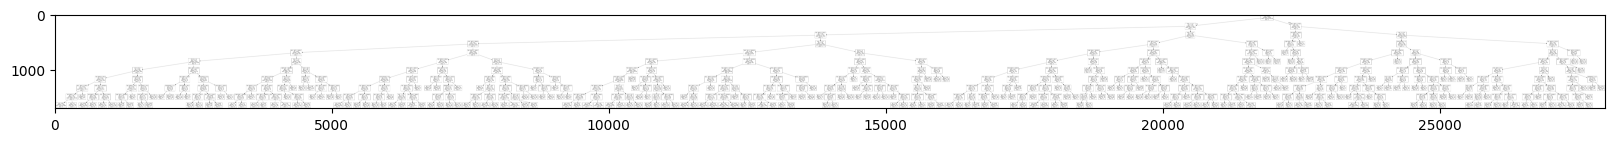

In [ ]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

### Make Predictions on the training and test data

In [ ]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

### Assess Model on Training and Test data

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("F1 Score.  : {:.4f}".format(f1_train))
print("")

# calculate the accuracy, precision, and recall score
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))
print("F1Score.  : {:.4f}".format(f1_test))

 -- train set -- 
Accuracy : 0.8418
Precision: 0.7431
Recall.  : 0.4324
F1 Score.  : 0.5467

 -- test set -- 
Accuracy : 0.8065
Precision: 0.6125
Recall.  : 0.3626
F1Score.  : 0.4555


### Generate a confusion matrix for the training and test data

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[15640  2624]
 [  691  1999]]
[[6516 1278]
 [ 460  727]]


### Generate ROC curves for training and test data

          FPR       TPR  Threshold
0    0.000000  0.000000        inf
1    0.000000  0.025957   1.000000
2    0.000061  0.032014   0.965517
3    0.000184  0.041964   0.958333
4    0.000429  0.057322   0.946667
..        ...       ...        ...
142  0.939991  0.999351   0.034483
143  0.941890  0.999567   0.031250
144  0.944339  0.999784   0.024390
145  0.954994  1.000000   0.005714
146  1.000000  1.000000   0.000000

[147 rows x 3 columns]


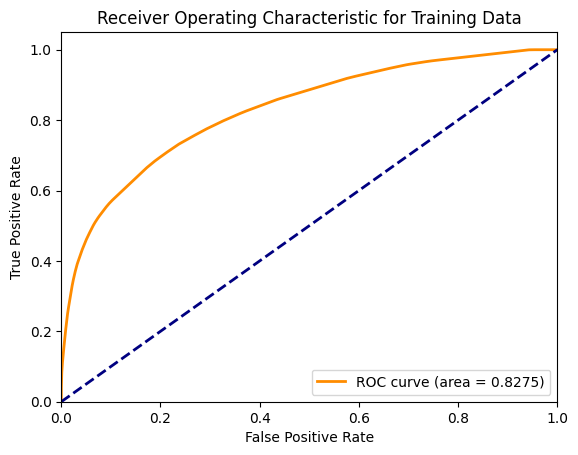

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

          FPR       TPR  Threshold
0    0.000000  0.000000        inf
1    0.002150  0.019950   1.000000
2    0.002867  0.025935   0.965517
3    0.003870  0.032419   0.958333
4    0.004587  0.040399   0.946667
..        ...       ...        ...
142  0.952265  0.956110   0.034483
143  0.953268  0.959102   0.031250
144  0.955275  0.964090   0.024390
145  0.964306  0.967082   0.005714
146  1.000000  1.000000   0.000000

[147 rows x 3 columns]


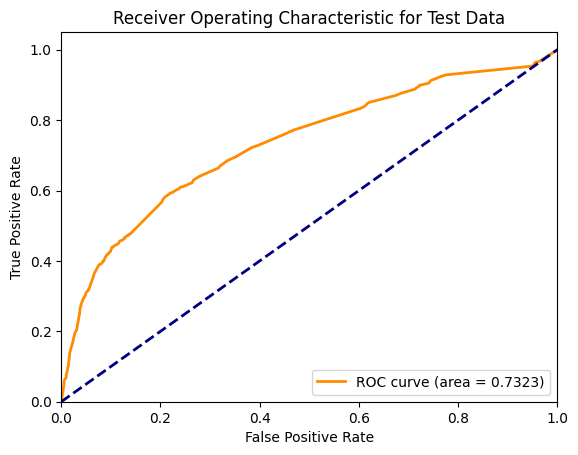

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

### Print feature importance for the tree

    importance    feature
5     0.509455      PAY_1
6     0.099296      PAY_2
18    0.051046   PAY_AMT2
11    0.035634  BILL_AMT1
19    0.027136   PAY_AMT3
0     0.025481  LIMIT_BAL
20    0.025064   PAY_AMT4
16    0.024528  BILL_AMT6
8     0.022538      PAY_4
12    0.022045  BILL_AMT2
4     0.021718        AGE
22    0.020792   PAY_AMT6
21    0.018964   PAY_AMT5
17    0.015091   PAY_AMT1
14    0.015088  BILL_AMT4
13    0.014521  BILL_AMT3
15    0.012567  BILL_AMT5
9     0.011613      PAY_5
10    0.009112      PAY_6
2     0.006457  EDUCATION
1     0.004195     GENDER
7     0.003959      PAY_3
3     0.003699   MARRIAGE


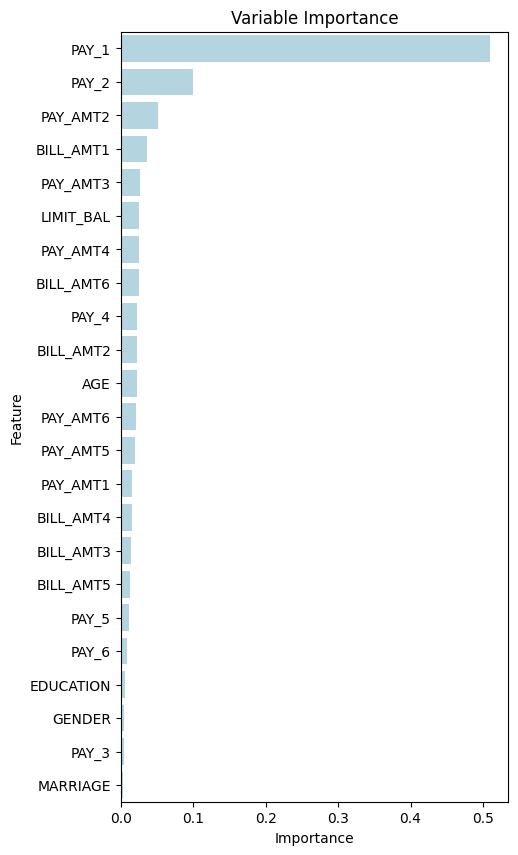

In [ ]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

## 2. Hyperparameter Tuning with GridSearchCV

### Find the best parameters using GridSearchCV

In [ ]:
# Create an instance of the classifier
dt_tune = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'ccp_alpha': [0.1, 0.001, 0.0001],
    'max_depth': [None, 20, 10, 5],
    'min_samples_leaf': [1, 20, 50,100],
}

# Execute the grid search
grid_search = GridSearchCV(dt_tune, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Print the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'ccp_alpha': 0.0001, 'max_depth': 5, 'min_samples_leaf': 1}
DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=5)


### Instantiate `DecisionTreeClassifier()` & Train the model

In [ ]:
# create an instance of a decision tree classifier using the parameters got in GridSearchCV

dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=1, ccp_alpha = 0.0001) #gridsearch

# fit the model to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=5)

### Visualize Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")


'decision_tree_default.pdf'

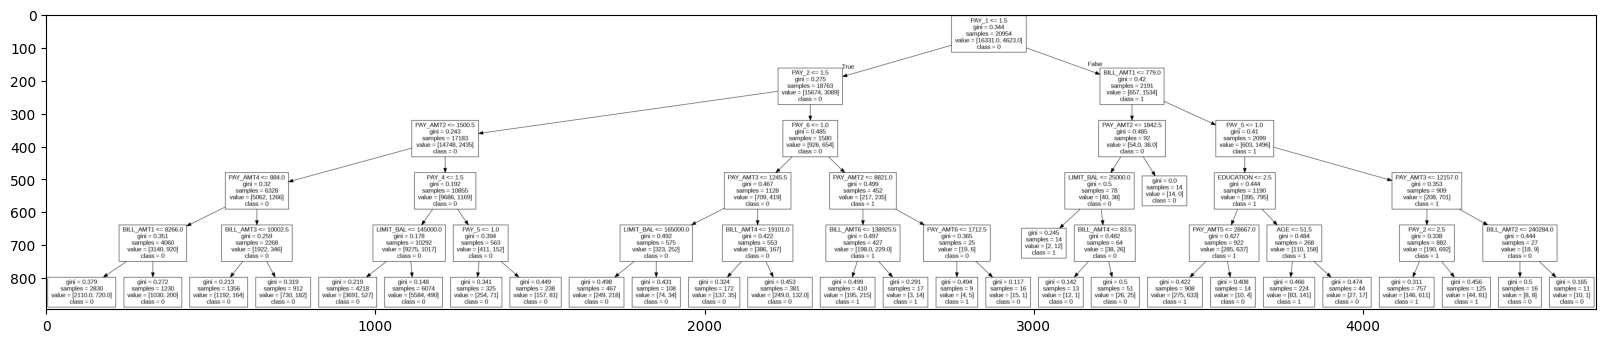

In [ ]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

### Make Predictions on the training and test data

In [ ]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

### Assess Model on Training and Test data

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("F1 Score.  : {:.4f}".format(f1_train))
print("")

# calculate the accuracy, precision, and recall score
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))
print("F1Score.  : {:.4f}".format(f1_test))

 -- train set -- 
Accuracy : 0.8252
Precision: 0.6948
Recall.  : 0.3703
F1 Score.  : 0.4831

 -- test set -- 
Accuracy : 0.8175
Precision: 0.6740
Recall.  : 0.3536
F1Score.  : 0.4639


### Generate a confusion matrix for the training and test data

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[15579  2911]
 [  752  1712]]
[[6633 1296]
 [ 343  709]]


### Generate ROC curves for training and test data

         FPR       TPR  Threshold
0   0.000000  0.000000        inf
1   0.000122  0.002596   0.857143
2   0.000306  0.005624   0.823529
3   0.009246  0.137789   0.807133
4   0.026085  0.274713   0.697137
5   0.028780  0.292234   0.648000
6   0.033862  0.322734   0.629464
7   0.034107  0.323816   0.555556
8   0.046047  0.370322   0.524390
9   0.046537  0.372053   0.500000
10  0.048129  0.377461   0.490196
11  0.063376  0.424616   0.466809
12  0.065030  0.428293   0.386364
13  0.080277  0.456846   0.346457
14  0.089890  0.474367   0.340336
15  0.094422  0.481722   0.314815
16  0.095034  0.482587   0.285714
17  0.224236  0.638330   0.254417
18  0.239789  0.653688   0.218462
19  0.248178  0.661259   0.203488
20  0.292879  0.700627   0.199561
21  0.355949  0.743889   0.162602
22  0.581961  0.857884   0.124941
23  0.654951  0.893359   0.120944
24  0.655563  0.893576   0.090909
25  0.997489  0.999567   0.080672
26  0.998224  0.999784   0.076923
27  0.999143  1.000000   0.062500
28  1.000000  

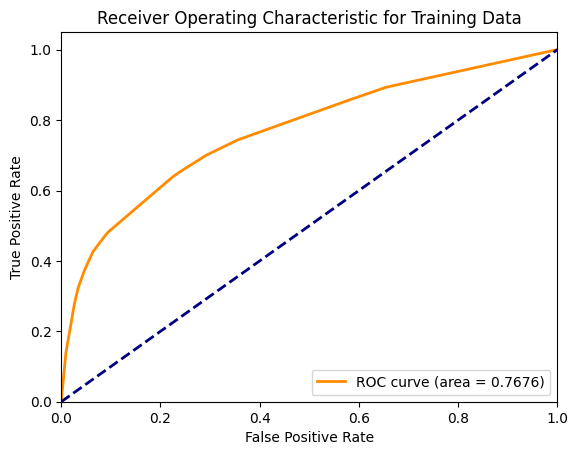

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

         FPR       TPR  Threshold
0   0.000000  0.000000        inf
1   0.000143  0.000998   0.857143
2   0.000143  0.002494   0.823529
3   0.009748  0.114713   0.807133
4   0.028670  0.249377   0.697137
5   0.031537  0.268329   0.648000
6   0.036841  0.303741   0.629464
7   0.036984  0.304239   0.555556
8   0.049169  0.353616   0.524390
9   0.049312  0.355112   0.500000
10  0.051175  0.362095   0.490196
11  0.067804  0.401995   0.466809
12  0.069667  0.408479   0.386364
13  0.084576  0.436409   0.346457
14  0.093177  0.451372   0.340336
15  0.099197  0.456858   0.314815
16  0.099771  0.458354   0.285714
17  0.225917  0.610973   0.254417
18  0.242403  0.631920   0.218462
19  0.249427  0.651372   0.203488
20  0.288704  0.677307   0.199561
21  0.351921  0.725187   0.162602
22  0.589306  0.845387   0.124941
23  0.664134  0.888778   0.120944
24  0.998997  0.997506   0.080672
25  0.999427  0.999002   0.076923
26  0.999857  1.000000   0.062500
27  1.000000  1.000000   0.000000


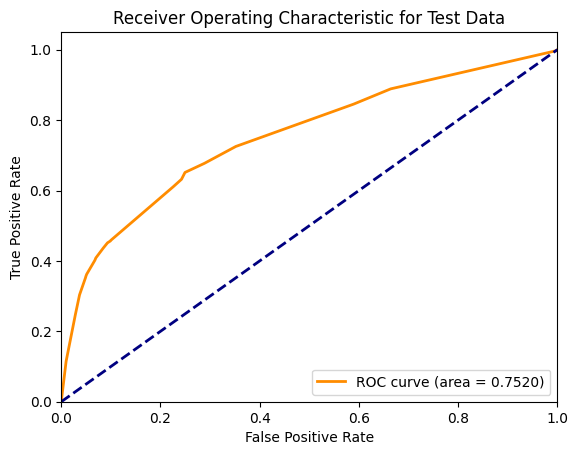

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

### Print feature importance for the tree

    importance    feature
5     0.700720      PAY_1
6     0.136925      PAY_2
18    0.048574   PAY_AMT2
8     0.019479      PAY_4
11    0.018860  BILL_AMT1
19    0.013164   PAY_AMT3
0     0.011509  LIMIT_BAL
20    0.009936   PAY_AMT4
9     0.009366      PAY_5
10    0.008858      PAY_6
14    0.005220  BILL_AMT4
13    0.004197  BILL_AMT3
21    0.002907   PAY_AMT5
4     0.002707        AGE
2     0.002656  EDUCATION
16    0.001819  BILL_AMT6
22    0.001744   PAY_AMT6
12    0.001359  BILL_AMT2
7     0.000000      PAY_3
1     0.000000     GENDER
15    0.000000  BILL_AMT5
17    0.000000   PAY_AMT1
3     0.000000   MARRIAGE


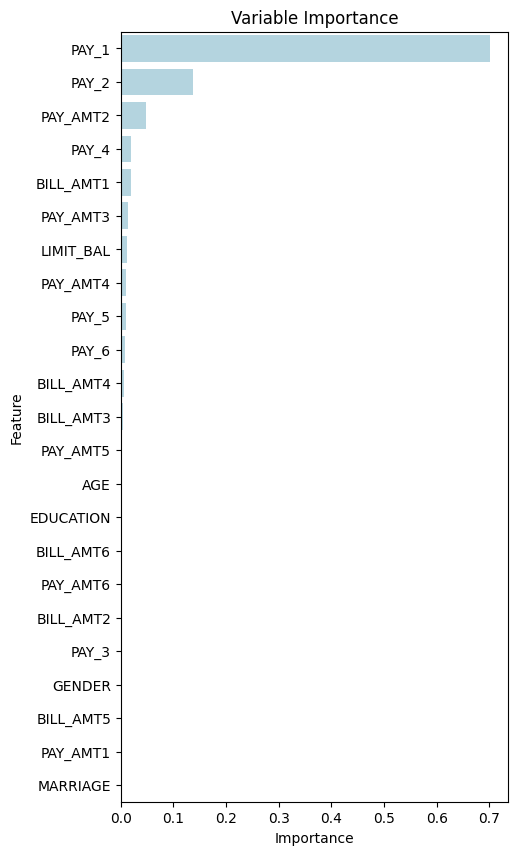

In [ ]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

## 3. Hyperparameter Tuning with RandomizedSearchCV

### Find the best parameters using RandomizedSearchCV

In [ ]:
# Create an instance of the classifier
rand_tune = DecisionTreeClassifier()

# Define the parameter distributions
param_dist = {
    'max_depth': randint(1, 50),  # Randomly search max_depth between 1 and 50
    'min_samples_leaf': randint(1, 100),  # Randomly search min_samples_leaf between 1 and 100
    'ccp_alpha': uniform(0.0, 0.1)  # Randomly search ccp_alpha between 0.0 and 0.1
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rand_tune, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'ccp_alpha': 0.03745401188473625, 'max_depth': 29, 'min_samples_leaf': 15}
Best cross-validation score: 0.4499869134771239


### Instantiate `DecisionTreeClassifier()` & Train the model

In [ ]:
# create an instance of a decision tree classifier using the parameters got in GridSearchCV

dt = DecisionTreeClassifier(max_depth = 29, min_samples_leaf=15, ccp_alpha = 0.03745401188473625) #randomizedsearch

# fit the model to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.03745401188473625, max_depth=29,
                       min_samples_leaf=15)

### Visualize Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")


'decision_tree_default.pdf'

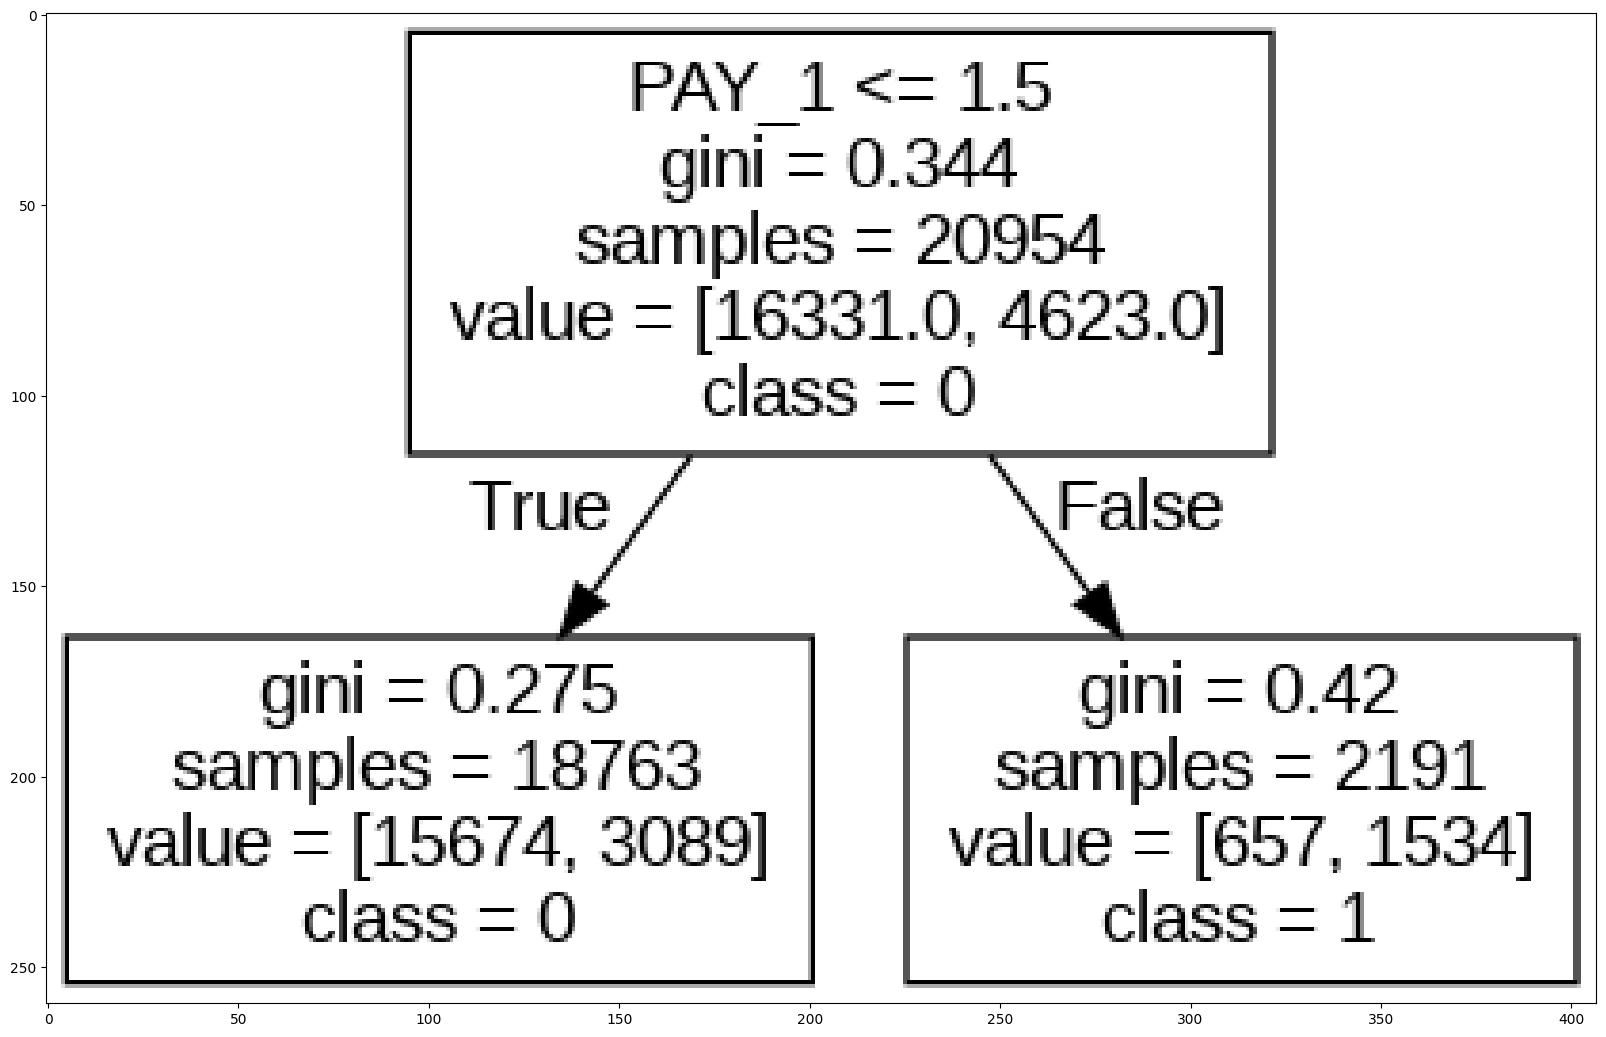

In [ ]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

### Make Predictions on the training and test data

In [ ]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

### Assess Model on Training and Test data

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("F1 Score.  : {:.4f}".format(f1_train))
print("")

# calculate the accuracy, precision, and recall score
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))
print("F1Score.  : {:.4f}".format(f1_test))

 -- train set -- 
Accuracy : 0.8212
Precision: 0.7001
Recall.  : 0.3318
F1 Score.  : 0.4502

 -- test set -- 
Accuracy : 0.8157
Precision: 0.6874
Recall.  : 0.3202
F1Score.  : 0.4369


### Generate a confusion matrix for the training and test data

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[15674  3089]
 [  657  1534]]
[[6684 1363]
 [ 292  642]]


### Generate ROC curves for training and test data

       FPR       TPR  Threshold
0  0.00000  0.000000        inf
1  0.04023  0.331819   0.700137
2  1.00000  1.000000   0.164633


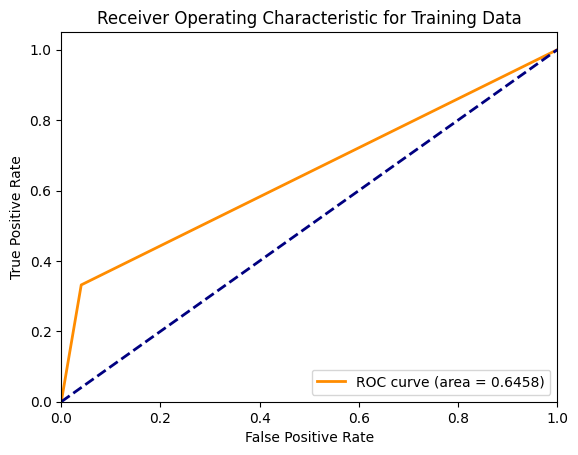

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

        FPR     TPR  Threshold
0  0.000000  0.0000        inf
1  0.041858  0.3202   0.700137
2  1.000000  1.0000   0.164633


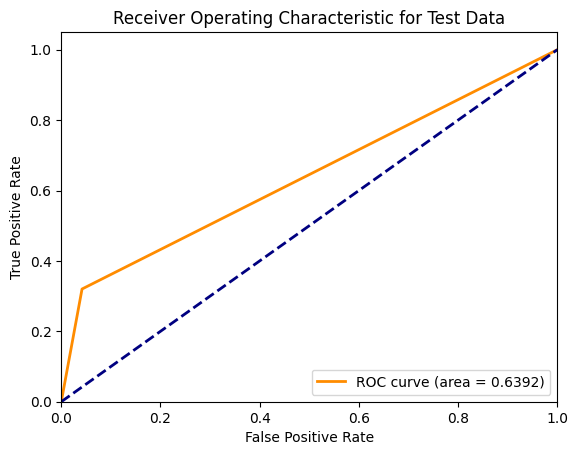

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

### Print feature importance for the tree

    importance    feature
5          1.0      PAY_1
0          0.0  LIMIT_BAL
12         0.0  BILL_AMT2
21         0.0   PAY_AMT5
20         0.0   PAY_AMT4
19         0.0   PAY_AMT3
18         0.0   PAY_AMT2
17         0.0   PAY_AMT1
16         0.0  BILL_AMT6
15         0.0  BILL_AMT5
14         0.0  BILL_AMT4
13         0.0  BILL_AMT3
11         0.0  BILL_AMT1
1          0.0     GENDER
10         0.0      PAY_6
9          0.0      PAY_5
8          0.0      PAY_4
7          0.0      PAY_3
6          0.0      PAY_2
4          0.0        AGE
3          0.0   MARRIAGE
2          0.0  EDUCATION
22         0.0   PAY_AMT6


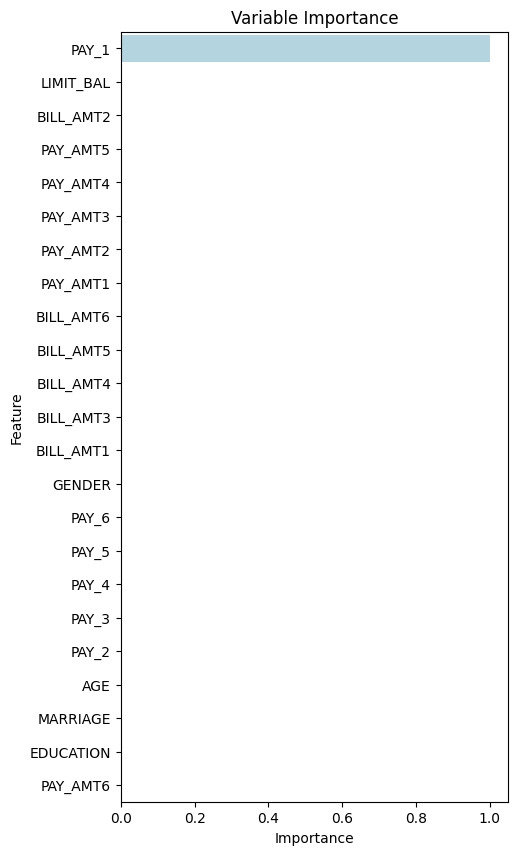

In [ ]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

## 4. Hyperparameter Tuning with Optuna

### Find the best parameters using Optuna

After running several times, we got the parameters with the best performance.

`max_depth`: 28,

`min_samples_leaf`: 5,

`ccp_alpha`: 0.00032902144056377175

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.1)

    opt_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alpha, random_state=42)

    score = cross_val_score(opt_tree, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print best parameters and best score
print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_value)

[I 2025-12-02 04:47:02,616] A new study created in memory with name: no-name-7a9312fc-c61c-407b-89f0-24e57617f6e8
[I 2025-12-02 04:47:04,193] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 12, 'min_samples_leaf': 69, 'ccp_alpha': 0.07920032669957822}. Best is trial 0 with value: 0.0.
[I 2025-12-02 04:47:06,317] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 25, 'min_samples_leaf': 40, 'ccp_alpha': 0.060373427505656455}. Best is trial 0 with value: 0.0.
[I 2025-12-02 04:47:10,588] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 16, 'min_samples_leaf': 61, 'ccp_alpha': 0.07741461981557488}. Best is trial 0 with value: 0.0.
[I 2025-12-02 04:47:12,532] Trial 3 finished with value: 0.4499869134771239 and parameters: {'max_depth': 6, 'min_samples_leaf': 46, 'ccp_alpha': 0.010375513263092773}. Best is trial 3 with value: 0.4499869134771239.
[I 2025-12-02 04:47:15,673] Trial 4 finished with value: 0.4499869134771239 and parameters: {'max_depth': 4

Best parameters: {'max_depth': 28, 'min_samples_leaf': 5, 'ccp_alpha': 0.00032902144056377175}
Best cross-validation score: 0.47858712364261374


### Instantiate `DecisionTreeClassifier()` & Train the model

In [ ]:
# create an instance of a decision tree classifier using the parameters got in Optuna

dt = DecisionTreeClassifier(
    max_depth = study.best_params['max_depth'],
    min_samples_leaf = study.best_params['min_samples_leaf'],
    ccp_alpha = study.best_params['ccp_alpha']) #optuna

# fit the model to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00032902144056377175, max_depth=28,
                       min_samples_leaf=5)

### Visualize Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")


'decision_tree_default.pdf'

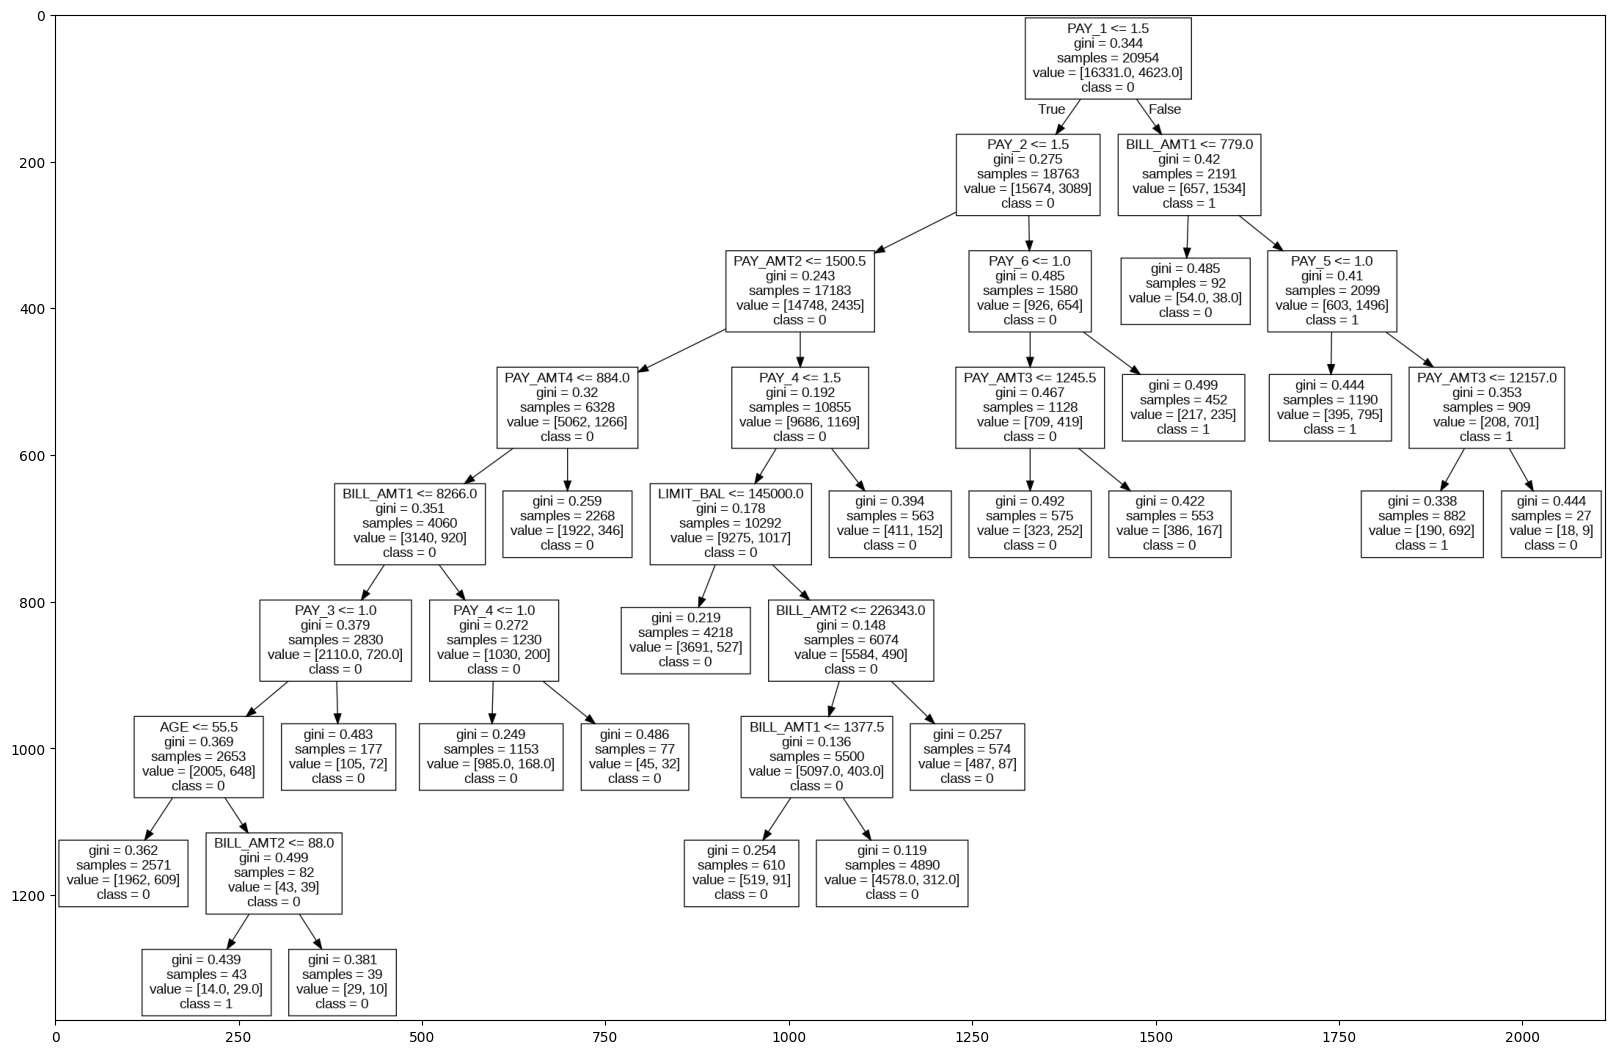

In [ ]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

### Make Predictions on the training and test data

In [ ]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

### Assess Model on Training and Test data

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("F1 Score.  : {:.4f}".format(f1_train))
print("")

# calculate the accuracy, precision, and recall score
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))
print("F1Score.  : {:.4f}".format(f1_test))

 -- train set -- 
Accuracy : 0.8240
Precision: 0.6821
Recall.  : 0.3788
F1 Score.  : 0.4871

 -- test set -- 
Accuracy : 0.8169
Precision: 0.6633
Recall.  : 0.3656
F1Score.  : 0.4714


### Generate a confusion matrix for the training and test data

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[15515  2872]
 [  816  1751]]
[[6604 1272]
 [ 372  733]]


### Generate ROC curves for training and test data

         FPR       TPR  Threshold
0   0.000000  0.000000        inf
1   0.011634  0.149686   0.784580
2   0.012492  0.155959   0.674419
3   0.036679  0.327926   0.668067
4   0.049966  0.378758   0.519912
5   0.069745  0.433268   0.438261
6   0.072500  0.440190   0.415584
7   0.075807  0.448410   0.413043
8   0.082236  0.463984   0.406780
9   0.083338  0.465931   0.333333
10  0.106974  0.502055   0.301989
11  0.132141  0.534934   0.269982
12  0.133917  0.537097   0.256410
13  0.254057  0.668830   0.236873
14  0.371747  0.743673   0.152557
15  0.401568  0.762492   0.151568
16  0.433348  0.782176   0.149180
17  0.493662  0.818516   0.145707
18  0.719674  0.932511   0.124941
19  1.000000  1.000000   0.063804


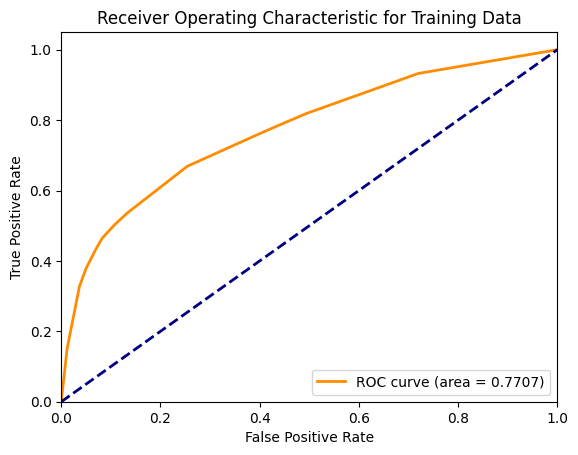

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

         FPR       TPR  Threshold
0   0.000000  0.000000        inf
1   0.012471  0.131172   0.784580
2   0.013905  0.135162   0.674419
3   0.040568  0.313217   0.668067
4   0.053326  0.365586   0.519912
5   0.075975  0.410973   0.438261
6   0.079558  0.419451   0.415584
7   0.082139  0.428928   0.413043
8   0.089736  0.445387   0.406780
9   0.089880  0.446883   0.333333
10  0.111812  0.494264   0.301989
11  0.136898  0.530175   0.269982
12  0.138905  0.531671   0.256410
13  0.254014  0.662344   0.236873
14  0.368119  0.731671   0.152557
15  0.396502  0.748628   0.151568
16  0.425315  0.771571   0.149180
17  0.484948  0.810973   0.145707
18  0.722334  0.931172   0.124941
19  1.000000  1.000000   0.063804


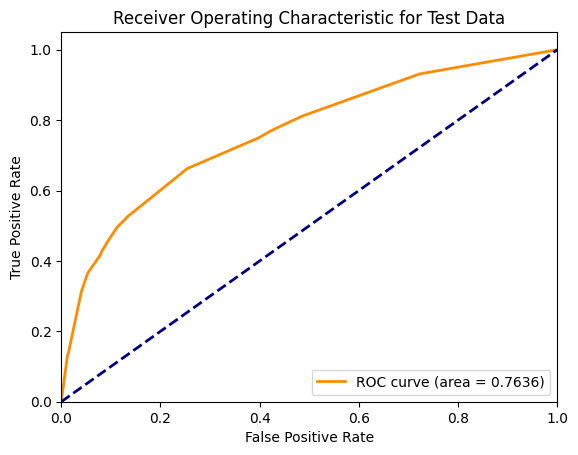

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

### Print feature importance for the tree

    importance    feature
5     0.707132      PAY_1
6     0.134764      PAY_2
18    0.042871   PAY_AMT2
8     0.026265      PAY_4
11    0.024002  BILL_AMT1
19    0.013284   PAY_AMT3
20    0.010027   PAY_AMT4
10    0.008939      PAY_6
12    0.008496  BILL_AMT2
9     0.006886      PAY_5
0     0.006132  LIMIT_BAL
4     0.005693        AGE
7     0.005509      PAY_3
1     0.000000     GENDER
13    0.000000  BILL_AMT3
14    0.000000  BILL_AMT4
15    0.000000  BILL_AMT5
16    0.000000  BILL_AMT6
17    0.000000   PAY_AMT1
3     0.000000   MARRIAGE
2     0.000000  EDUCATION
21    0.000000   PAY_AMT5
22    0.000000   PAY_AMT6


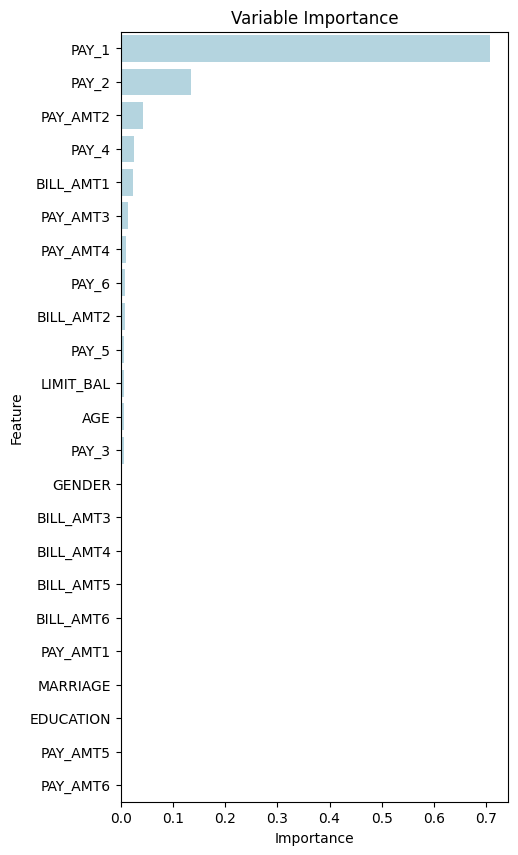

In [ ]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

# Model 2: Random Forest Model

## Untuned Model Training

In [ ]:
# create an instance of a random forest classifier using default values for RF and restrictive values for tree

rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=15, min_samples_leaf=50, random_state=904)

# fit the model to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=50, random_state=904)

### Make predictions on training and test set

In [ ]:
# make predictions on the training and test data
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

y_prob_train_rf = rf.predict_proba(X_train)
y_prob_test_rf = rf.predict_proba(X_test)

### Assess model on training and test set - include F1 Score

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train_rf)
prec_train = precision_score(y_train, y_pred_train_rf)
rec_train = recall_score(y_train, y_pred_train_rf)
f1_train = f1_score(y_train, y_pred_train_rf)


# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("F1 Score.  : {:.4f}".format(f1_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test_rf)
prec_test = precision_score(y_test, y_pred_test_rf)
rec_test = recall_score(y_test, y_pred_test_rf)
f1_test = f1_score(y_test, y_pred_test_rf)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))
print("F1 Score.  : {:.4f}".format(f1_test))

 -- train set -- 
Accuracy : 0.8261
Precision: 0.7042
Recall.  : 0.3651
F1 Score.  : 0.4809

 -- test set -- 
Accuracy : 0.8176
Precision: 0.6776
Recall.  : 0.3491
F1 Score.  : 0.4608


### Generate confusion matrix for training and test set

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train_rf, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test_rf, y_test)
print(conf_matrix)

[[15622  2935]
 [  709  1688]]
[[6643 1305]
 [ 333  700]]


### Generate ROC curves for training and test data and review the FPR and TPR

           FPR       TPR  Threshold
0     0.000000  0.000000        inf
1     0.000000  0.000216   0.831829
2     0.000000  0.001947   0.819825
3     0.000000  0.002379   0.819321
4     0.000000  0.003245   0.816928
...        ...       ...        ...
5281  0.936991  0.999567   0.050614
5282  0.936991  0.999784   0.050613
5283  0.951932  0.999784   0.046214
5284  0.951932  1.000000   0.046173
5285  1.000000  1.000000   0.015264

[5286 rows x 3 columns]


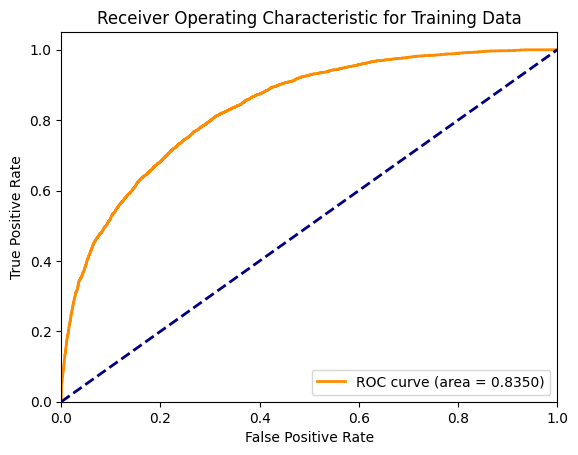

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train_rf[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train_rf[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

           FPR       TPR  Threshold
0     0.000000  0.000000        inf
1     0.000000  0.000499   0.825780
2     0.000000  0.006983   0.801577
3     0.000143  0.006983   0.801492
4     0.000143  0.007481   0.800420
...        ...       ...        ...
2438  0.989966  0.999002   0.029172
2439  0.989966  0.999501   0.029146
2440  0.996130  0.999501   0.024827
2441  0.996130  1.000000   0.024442
2442  1.000000  1.000000   0.016836

[2443 rows x 3 columns]
           FPR       TPR  Threshold
1701  0.414994  0.790524   0.156417
1702  0.416858  0.790524   0.156273
1703  0.416858  0.791521   0.156219
1704  0.417001  0.791521   0.156193
1705  0.417001  0.792020   0.156187
...        ...       ...        ...
1766  0.452265  0.808978   0.148881
1767  0.452265  0.809476   0.148874
1768  0.453268  0.809476   0.148738
1769  0.453268  0.809975   0.148652
1770  0.453412  0.809975   0.148643

[70 rows x 3 columns]


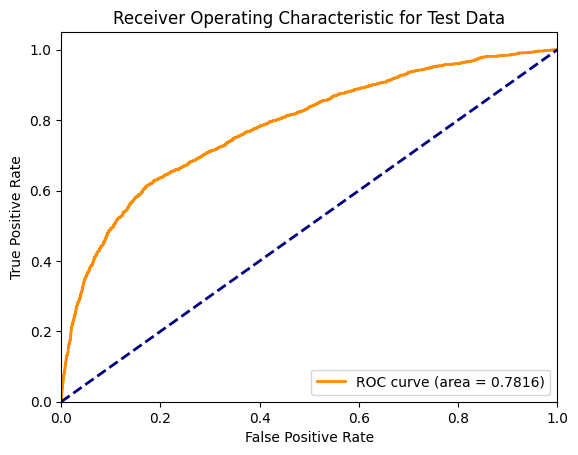

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test_rf[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test_rf[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

best_TPR_rows = roc_df[(roc_df['TPR'] >= 0.79) & (roc_df['TPR'] <= 0.81)]

# Print the rows
print(best_TPR_rows)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


## Hyperparameter Tuning (Optuna)

### Find the best parameters using Optuna

Because of limited computing power, we would only use Random Forest Model with default values for comparison and comment out the fine-tuning process.

In [ ]:
# Define the Objective Function for Optuna ---
def rf_objective(trial):
    '''Suggest a range for key Random Forest hyperparameters'''
    params = {
        # n_estimators: Number of trees in the forest (must be an integer)
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),

        # max_depth: Maximum depth of each tree (integer, None means no limit)
        'max_depth': trial.suggest_int('max_depth', 5, 30, log=True),

        # min_samples_leaf: Minimum number of samples required at a leaf node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),

        # max_features: The number of features to consider when looking for the best split
        # We sample a fraction between 0.5 (50%) and 1.0 (100%) of features
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),

        # criterion: The function to measure the quality of a split
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),

        'random_state': 42
    }

    # Instantiate and evaluate the model using cross-validation
    rf_model = RandomForestClassifier(**params)

    # We use a reduced cv=3 for speed during the intensive hyperparameter search
    score = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1).mean()

    return score

In [ ]:
# # Create Study and Run Optimization
# # The direction is 'maximize' because a higher F1-score is better.
# study = optuna.create_study(direction='maximize', study_name='RandomForest_Tuning')

# # Run 50 trials considering limited computing time
# study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

In [ ]:
# # Output Best Results
# rf_best_params = study.best_params
# rf_best_f1 = study.best_value

# print(f"Best Random Forest CV F1 Score: {rf_best_f1:.4f}")
# print("Optimal Hyperparameters:")
# for key, value in rf_best_params.items():
#     print(f"  {key}: {value}")

# Model 3: Gradient Boosting Model

## Untuned Model Training

In [ ]:
# create an instance of the Gradient Boosting Classifier using default values

gb = GradientBoostingClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth=3,
    random_state=904)

# fit the model to the training data
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=904)

### Make Predictions on Training and Test Set

In [ ]:
# make predictions on the training and test data
y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb = gb.predict(X_test)

y_prob_train_gb = gb.predict_proba(X_train)
y_prob_test_gb = gb.predict_proba(X_test)


### Assess model on training and test set - include F1 score

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train_gb)
prec_train = precision_score(y_train, y_pred_train_gb)
rec_train = recall_score(y_train, y_pred_train_gb)
f1_train = f1_score(y_train, y_pred_train_gb)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("F1 Score.  : {:.4f}".format(f1_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test_gb)
prec_test = precision_score(y_test, y_pred_test_gb)
rec_test = recall_score(y_test, y_pred_test_gb)
f1_test = f1_score(y_test, y_pred_test_gb)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))
print("F1 Score.  : {:.4f}".format(f1_test))

 -- train set -- 
Accuracy : 0.8281
Precision: 0.6998
Recall.  : 0.3863
F1 Score.  : 0.4978

 -- test set -- 
Accuracy : 0.8158
Precision: 0.6597
Recall.  : 0.3616
F1 Score.  : 0.4671


### Generate confusion matrix for training and test set

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train_gb, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test_gb, y_test)
print(conf_matrix)

[[15565  2837]
 [  766  1786]]
[[6602 1280]
 [ 374  725]]


### Generate ROC curves for training and test data and review the FPR and TPR

           FPR       TPR  Threshold
0     0.000000  0.000000        inf
1     0.000000  0.000216   0.921871
2     0.000000  0.002596   0.883630
3     0.000000  0.003028   0.883042
4     0.000000  0.003245   0.882443
...        ...       ...        ...
6017  0.992591  0.999784   0.038288
6018  0.994550  0.999784   0.037148
6019  0.994673  0.999784   0.037138
6020  0.994673  1.000000   0.037117
6021  1.000000  1.000000   0.026553

[6022 rows x 3 columns]


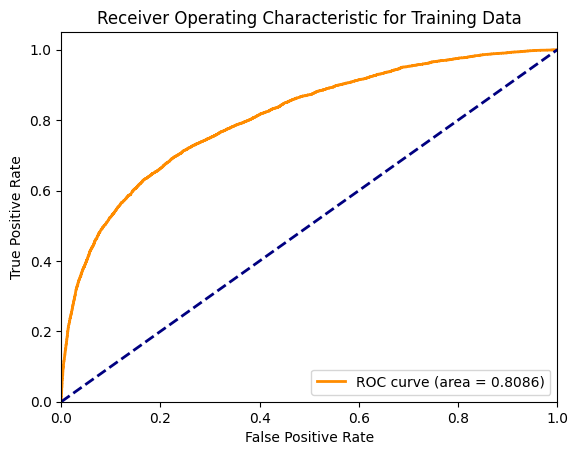

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train_gb[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train_gb[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

           FPR       TPR  Threshold
0     0.000000  0.000000        inf
1     0.000000  0.000499   0.904155
2     0.000000  0.006484   0.843278
3     0.000143  0.006484   0.842759
4     0.000143  0.007980   0.839618
...        ...       ...        ...
2634  0.997563  0.999002   0.035601
2635  0.997563  0.999501   0.035324
2636  0.999857  0.999501   0.031828
2637  0.999857  1.000000   0.031472
2638  1.000000  1.000000   0.031435

[2639 rows x 3 columns]
           FPR       TPR  Threshold
1691  0.416858  0.790025   0.143260
1692  0.420442  0.790025   0.142387
1693  0.420442  0.790524   0.142367
1694  0.420872  0.790524   0.142276
1695  0.420872  0.791022   0.142271
...        ...       ...        ...
1754  0.442804  0.809476   0.137337
1755  0.445384  0.809476   0.136752
1756  0.445384  0.809975   0.136733
1757  0.445671  0.809975   0.136720
1758  0.446244  0.809975   0.136658

[68 rows x 3 columns]


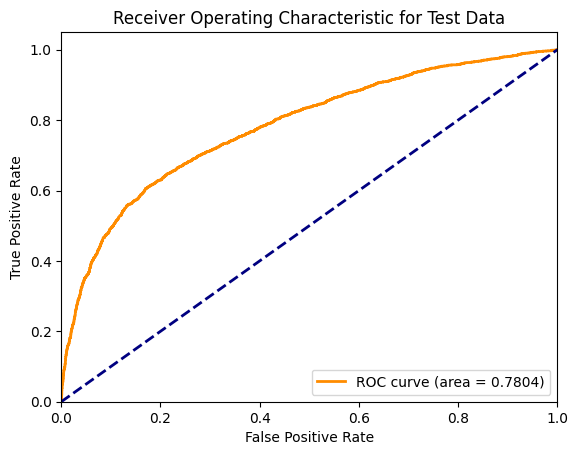

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test_gb[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test_gb[:,1])

#print out the fpr, tpr, and threshold values
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ['FPR', 'TPR', 'Threshold'])
print(roc_df)

best_TPR_rows = roc_df[(roc_df['TPR'] >= 0.79) & (roc_df['TPR'] <= 0.81)]

# Print the rows
print(best_TPR_rows)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


### Print feature importance for the tree

    importance    feature
5     0.619892      PAY_1
6     0.082198      PAY_2
11    0.029538  BILL_AMT1
7     0.028683      PAY_3
0     0.027468  LIMIT_BAL
18    0.025578   PAY_AMT2
19    0.022931   PAY_AMT3
17    0.022678   PAY_AMT1
8     0.018562      PAY_4
10    0.014841      PAY_6
9     0.014572      PAY_5
22    0.011986   PAY_AMT6
21    0.011496   PAY_AMT5
4     0.011414        AGE
13    0.010300  BILL_AMT3
20    0.009158   PAY_AMT4
12    0.008652  BILL_AMT2
16    0.007772  BILL_AMT6
14    0.006786  BILL_AMT4
15    0.005706  BILL_AMT5
2     0.005310  EDUCATION
3     0.002492   MARRIAGE
1     0.001989     GENDER


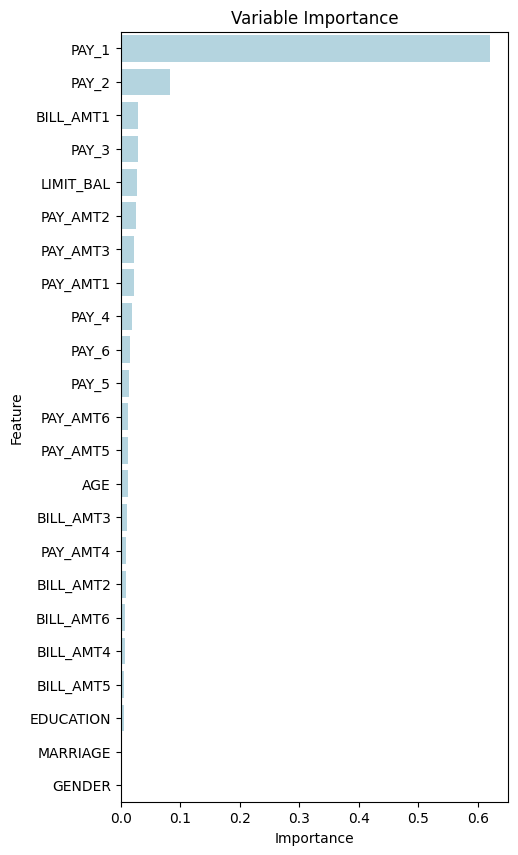

In [ ]:
#calculate feature importance
tree_imp = gb.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

## Hyperparameter Tuning using Feature Engineering
Use autofeat to do automated featrue engineering before fitting the same GB model

However, because of limited computing power, we would only use Gradient Boosting Model with default values for comparison and comment out the fine-tuning process.

In [ ]:
# # Initialize and fit the AutoFeatClassifier for feature engineering
# af = AutoFeatClassifier(verbose=1)
# X_train_transformed = af.fit_transform(X_train, y_train)
# X_test_transformed = af.transform(X_test)

# # Create an instance of a gradient boosting model
# gb_new = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth=3, random_state=904)

# # fit the model to the transformed training data
# gb_new.fit(X_train_transformed, y_train)

In [ ]:
# # make predictions on the transformed training and transformed test data
# y_pred_train_gbnew = gb_new.predict(X_train_transformed)
# y_pred_test_gbnew = gb_new.predict(X_test_transformed)

# y_prob_train_gbnew = gb_new.predict_proba(X_train_transformed)
# y_prob_test_gbnew = gb_new.predict_proba(X_test_transformed)

In [ ]:
# # calculate the accuracy, precision, and recall scores
# acc_train = accuracy_score(y_train, y_pred_train_gbnew)
# prec_train = precision_score(y_train, y_pred_train_gbnew)
# rec_train = recall_score(y_train, y_pred_train_gbnew)
# f1_train = f1_score(y_train, y_pred_train_gbnew)

# # print the scores
# print(" -- train set -- ")
# print("Accuracy : {:.4f}".format(acc_train))
# print("Precision: {:.4f}".format(prec_train))
# print("Recall.  : {:.4f}".format(rec_train))
# print("F1 Score.  : {:.4f}".format(f1_train))
# print("")

# # calculate the accuracy, precision, and recall scores
# acc_test = accuracy_score(y_test, y_pred_test_gbnew)
# prec_test = precision_score(y_test, y_pred_test_gbnew)
# rec_test = recall_score(y_test, y_pred_test_gbnew)
# f1_test = f1_score(y_test, y_pred_test_gbnew)

# print(" -- test set -- ")
# print("Accuracy : {:.4f}".format(acc_test))
# print("Precision: {:.4f}".format(prec_test))
# print("Recall.  : {:.4f}".format(rec_test))
# print("F1 Score.  : {:.4f}".format(f1_test))

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score

# # Make predictions on the training and test data
# y_pred_train_ag = predictor.predict(X_train)
# y_pred_test_ag = predictor.predict(X_test)


# # Calculate and print metrics for the training set
# acc_train_ag = accuracy_score(y_train, y_pred_train_ag)
# prec_train_ag = precision_score(y_train, y_pred_train_ag)
# rec_train_ag = recall_score(y_train, y_pred_train_ag)

# print(" -- AutoGluon Train Set Metrics -- ")
# print("Accuracy : {:.4f}".format(acc_train_ag))
# print("Precision: {:.4f}".format(prec_train_ag))
# print("Recall.  : {:.4f}".format(rec_train_ag))
# print("")

# # Calculate and print metrics for the test set
# acc_test_ag = accuracy_score(y_test, y_pred_test_ag)
# prec_test_ag = precision_score(y_test, y_pred_test_ag)
# rec_test_ag = recall_score(y_test, y_pred_test_ag)

# print(" -- AutoGluon Test Set Metrics -- ")
# print("Accuracy : {:.4f}".format(acc_test_ag))
# print("Precision: {:.4f}".format(prec_test_ag))
# print("Recall.  : {:.4f}".format(rec_test_ag))

In [ ]:
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install autogluon

Now I will use AutoGluon to fit a model to the data.

In [ ]:
# from autogluon.tabular import TabularPredictor

# predictor = TabularPredictor(label='Popular').fit(train_data=pd.concat([X_train, y_train], axis=1))

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score

# # Make predictions on the training and test data
# y_pred_train_ag = predictor.predict(X_train)
# y_pred_test_ag = predictor.predict(X_test)

# # Convert predictions to the same category type as the true labels
# y_pred_train_ag = y_pred_train_ag.astype(y_train.dtype)
# y_pred_test_ag = y_pred_test_ag.astype(y_test.dtype)


# # Calculate and print metrics for the training set
# acc_train_ag = accuracy_score(y_train, y_pred_train_ag)
# prec_train_ag = precision_score(y_train, y_pred_train_ag)
# rec_train_ag = recall_score(y_train, y_pred_train_ag)

# print(" -- AutoGluon Train Set Metrics -- ")
# print("Accuracy : {:.4f}".format(acc_train_ag))
# print("Precision: {:.4f}".format(prec_train_ag))
# print("Recall.  : {:.4f}".format(rec_train_ag))
# print("")

# # Calculate and print metrics for the test set
# acc_test_ag = accuracy_score(y_test, y_pred_test_ag)
# prec_test_ag = precision_score(y_test, y_pred_test_ag)
# rec_test_ag = recall_score(y_test, y_pred_test_ag)

# print(" -- AutoGluon Test Set Metrics -- ")
# print("Accuracy : {:.4f}".format(acc_test_ag))
# print("Precision: {:.4f}".format(prec_test_ag))
# print("Recall.  : {:.4f}".format(rec_test_ag))

# Overall Model Assessment and Analysis

## Comparison of Metrics across all Models

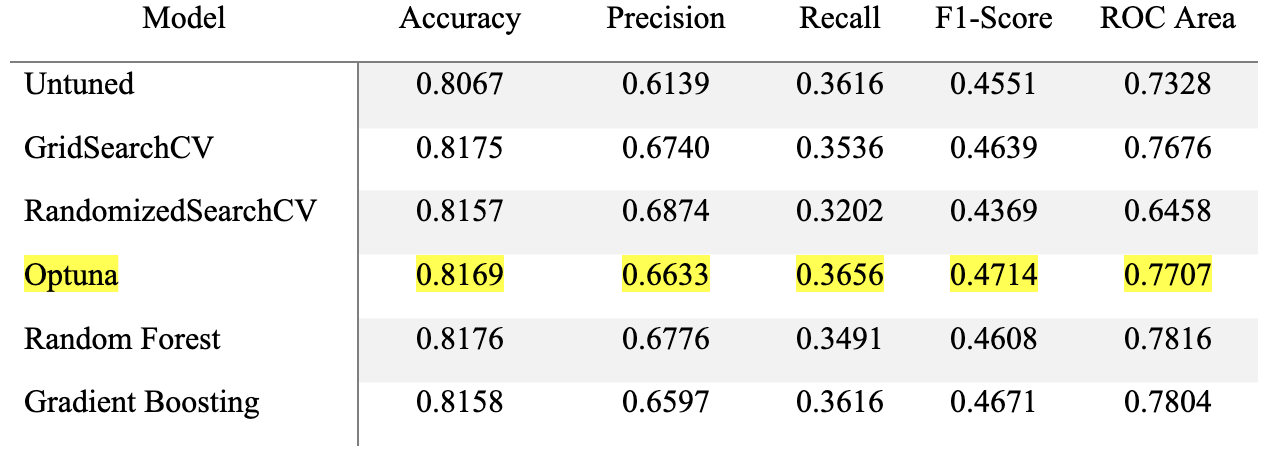

Comparing all the models, we choose the **Optuna-tuned Single Classification Tree Model** as our final model. Because banks care more about correctly predicting the actual defaulters, we specifically focus on metrics Recall (which demonstrates the model’s performance in identifying the proportion of correctly predicted outcomes in terms of actual positive results) and F1-score, which is the harmonic mean of Precision and Recall that measures the model’s ability to correctly identify both classes, especially when they are imbalanced.

From the spreadsheet, we can see that the Optuna-tuned Single Classification Tree Model achieves an F1-Score of 0.4714 and a Recall of 0.3656, which are relatively high compared to other models.